# HOME CREDIT SCORECARD MODEL

In [123]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_auc_score 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [124]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [125]:
# data application (train)
df = pd.read_csv("C:\\Users\\garini\\Downloads\\home-credit-default-risk\\application_train.csv", sep=',')
print('This dataset has %d rows dan %d columns.\n' % df.shape)
df.head()

This dataset has 307511 rows dan 122 columns.



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

There are total 307,511 rows which contains the information of loans and there are 122 features.

## Exploratory Data Analysis

#### Check Data Type

In [126]:
print(df.dtypes)

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                     object
FLAG_OWN_REALTY                  object
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [144]:
df_train = df.copy()

#### The number of customers who apply for loans

In [142]:
noc = df.groupby('TARGET')['CODE_GENDER'].count().reset_index()
noc.rename(columns = {'CODE_GENDER' : 'Customers'}, inplace=True)

noc['Customers_pct'] = round(noc.Customers / noc.Customers.sum(), 2)
noc

,TARGET,Customers,Customers_pct
0,0,282686,0.92
1,1,24825,0.08


From the table above, it can be seen that 92% did not experience problems in paying off the loan within a certain period of time and 8% experienced problems, so let's find out according to the criteria whether customers do not experience problems in paying off the loan

In [145]:
decode_map = {0: "No Payment Difficulties", 1: "Payment Difficulties"}
def decode_sentiment(label):
    return decode_map[int(label)]

df_train['TARGET'] = df_train['TARGET'].apply(lambda x: decode_sentiment(x))

In [147]:
target_pp= (df_train[['TARGET']]
                .groupby("TARGET")
                .agg(COUNT=("TARGET","count"))
                .sort_values(by=["COUNT"],ascending=False)
                .reset_index()
                )

target_pp.style.background_gradient(cmap='Blues')

,TARGET,COUNT
0,No Payment Difficulties,282686
1,Payment Difficulties,24825


In [148]:
pp= df_train['TARGET'].value_counts(normalize=True)
pp.reset_index().style.background_gradient(cmap='Blues')

,index,TARGET
0,No Payment Difficulties,0.919271
1,Payment Difficulties,0.080729


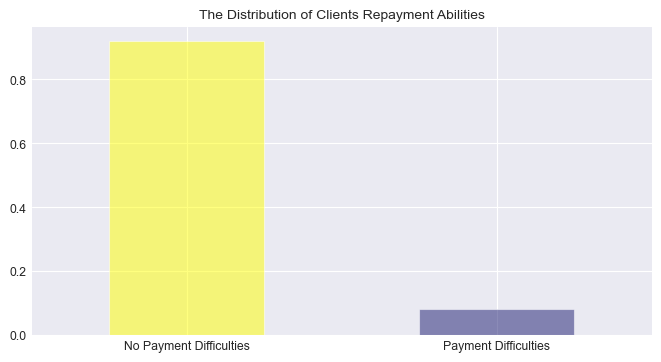

In [150]:
fig = plt.figure(figsize = (8,4))
grp.plot(kind='bar', color= ['yellow','midnightblue'], alpha = 0.5, rot=0)
plt.title('The Distribution of Clients Repayment Abilities', fontsize=10)
plt.show()

There are around 91% with `TARGET` = 0, which indicates that the client has no problems paying off the loan within a certain time. The remaining 9% of the total client loans experienced problems in repaying their loans

##### Contract Type, Gender, Car Ownership Status, and Realty Ownership Status

<AxesSubplot:title={'center':'\nClients Repayment Abilities By Realty Ownership Status\n'}, xlabel='FLAG_OWN_REALTY', ylabel='count'>

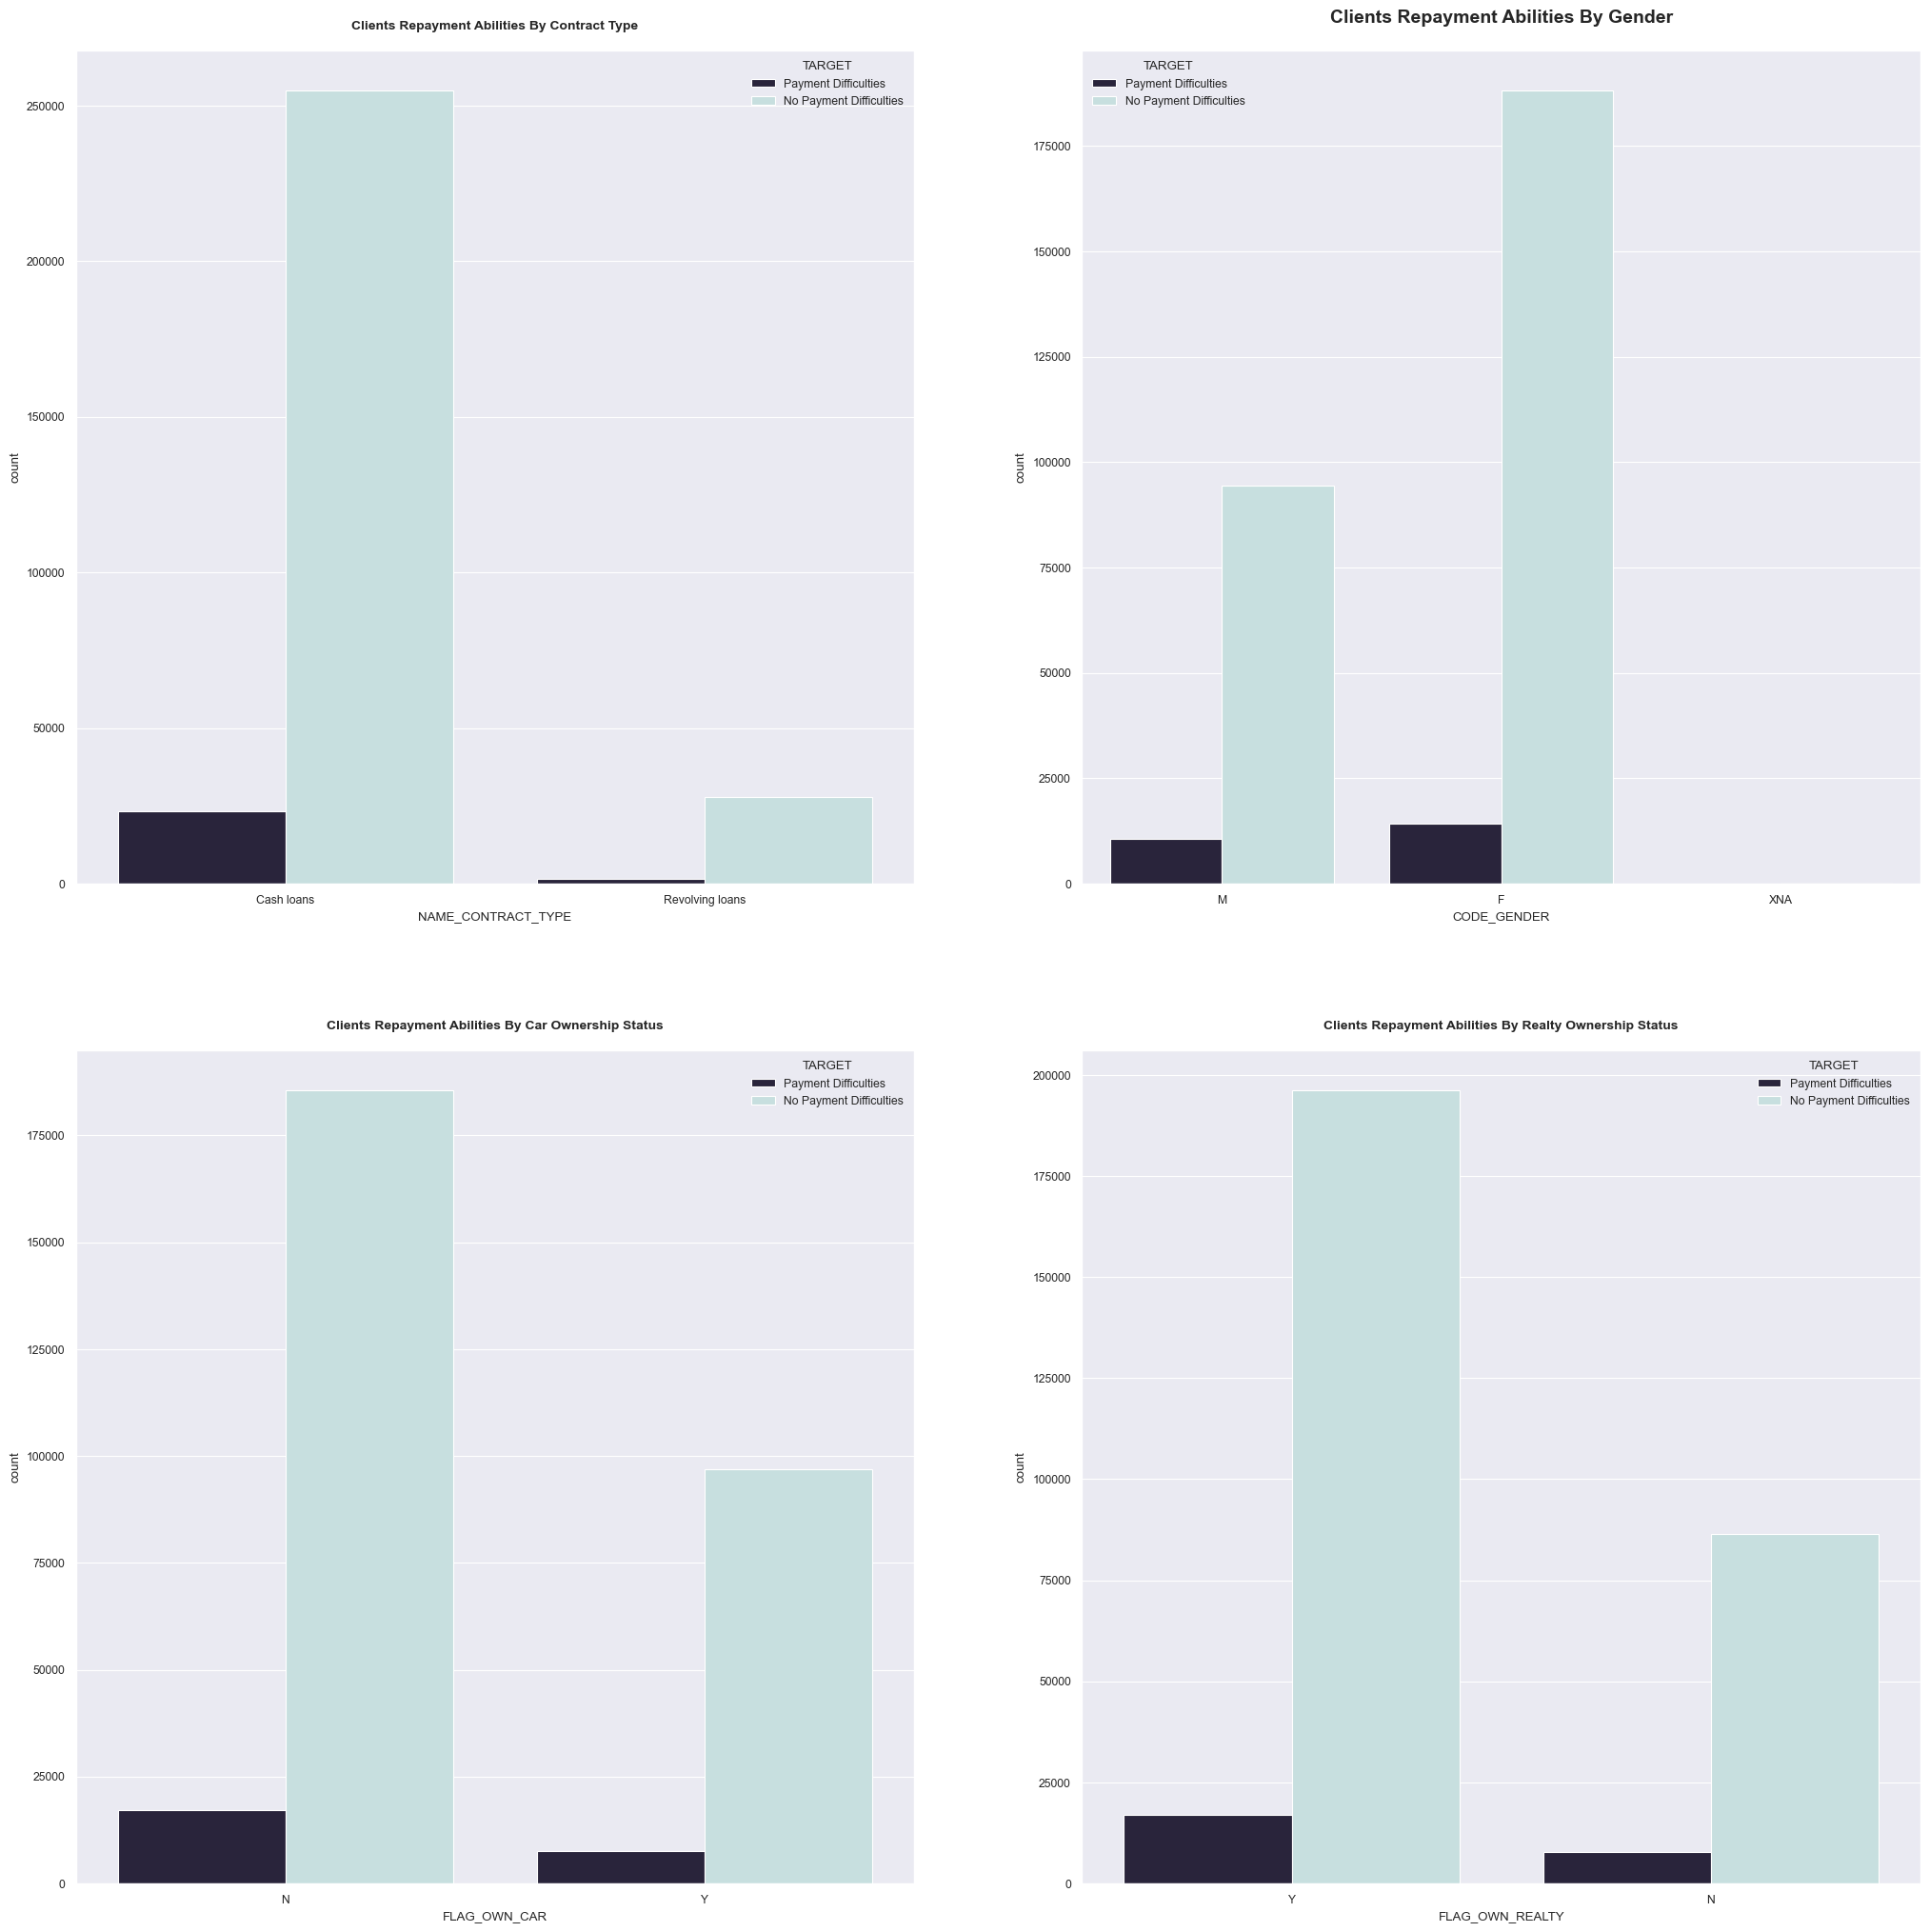

In [154]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(2,2, figsize=(25,25))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Contract Type\n', fontweight='bold', fontsize=10)
sns.countplot(x='NAME_CONTRACT_TYPE', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Gender\n', fontweight='bold', fontsize=14)
sns.countplot(x='CODE_GENDER', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Car Ownership Status\n', fontweight='bold', fontsize=10)
sns.countplot(x='FLAG_OWN_CAR', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Realty Ownership Status\n', fontweight='bold', fontsize=10)
sns.countplot(x='FLAG_OWN_REALTY', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

##### Contract Type Vs Target

In [156]:
ct = df_train.groupby(by=['NAME_CONTRACT_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Contract Type')
ct.sort_values(by='SK_ID_CURR', ascending=False)
ct.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Contract Type


,NAME_CONTRACT_TYPE,TARGET,SK_ID_CURR
0,Cash loans,No Payment Difficulties,255011
1,Cash loans,Payment Difficulties,23221
2,Revolving loans,No Payment Difficulties,27675
3,Revolving loans,Payment Difficulties,1604


Cash loans with approximately 278 thousand loans make up the majority of total loans in this data set and
Revolving loans have a much lower amount of around 29 thousand compared to cash loans

#### Target vs Gender

In [12]:
df_train['CODE_GENDER'] = df_train['CODE_GENDER'].replace(['F','M'],['Female','Male'])

In [158]:
tg = df_train.groupby(by=['CODE_GENDER','TARGET'], as_index=False)['SK_ID_CURR'].count()
tg.sort_values(by='SK_ID_CURR', ascending=False)
tg.style.background_gradient(cmap='Blues')

,CODE_GENDER,TARGET,SK_ID_CURR
0,F,No Payment Difficulties,188278
1,F,Payment Difficulties,14170
2,M,No Payment Difficulties,94404
3,M,Payment Difficulties,10655
4,XNA,No Payment Difficulties,4


In [159]:
df[['CODE_GENDER','TARGET']].groupby(['CODE_GENDER'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,CODE_GENDER,TARGET
1,M,0.101419
0,F,0.069993
2,XNA,0.000000


It can be seen that more women apply for loans. In total, there were around 202,448 loan applications submitted by women, and around 105,059 applications submitted by men

##### Target vs Car Ownership Status

In [15]:
df_train['FLAG_OWN_CAR'] = df_train['FLAG_OWN_CAR'].replace(['Y','N'],['Yes','No'])

In [161]:
tc = df_train.groupby(by=['FLAG_OWN_CAR','TARGET'], as_index=False)['SK_ID_CURR'].count()
tc.sort_values(by='SK_ID_CURR', ascending=False)
tc.style.background_gradient(cmap='Blues')

,FLAG_OWN_CAR,TARGET,SK_ID_CURR
0,N,No Payment Difficulties,185675
1,N,Payment Difficulties,17249
2,Y,No Payment Difficulties,97011
3,Y,Payment Difficulties,7576


In [162]:
df[['FLAG_OWN_CAR','TARGET']].groupby(['FLAG_OWN_CAR'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_CAR,TARGET
0,N,0.085002
1,Y,0.072437


Most clients do not own cars 8% of customers who own a car experience difficulty in paying back their loans compared to 7% of customers who don't own a car

##### Realty Ownership Status Vs Target

In [18]:
df_train['FLAG_OWN_REALTY'] = df_train['FLAG_OWN_REALTY'].replace(['Y','N'],['Yes','No'])

In [163]:
tr = df_train.groupby(by=['FLAG_OWN_REALTY','TARGET'], as_index=False)['SK_ID_CURR'].count()
tr.sort_values(by='SK_ID_CURR', ascending=False)
tr.style.background_gradient(cmap='Blues')

,FLAG_OWN_REALTY,TARGET,SK_ID_CURR
0,N,No Payment Difficulties,86357
1,N,Payment Difficulties,7842
2,Y,No Payment Difficulties,196329
3,Y,Payment Difficulties,16983


In [164]:
df[['FLAG_OWN_REALTY','TARGET']].groupby(['FLAG_OWN_REALTY'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,FLAG_OWN_REALTY,TARGET
0,N,0.083249
1,Y,0.079616


The number of customers who own a house/flat is 8% and has problems in repaying the loan compared to customers who do not own a house/flat which is 7%.

##### Suite Type, Income Type, Education Type, and Family Status

<AxesSubplot:title={'center':'\nClients Repayment Abilities By Family Status\n'}, xlabel='NAME_FAMILY_STATUS', ylabel='count'>

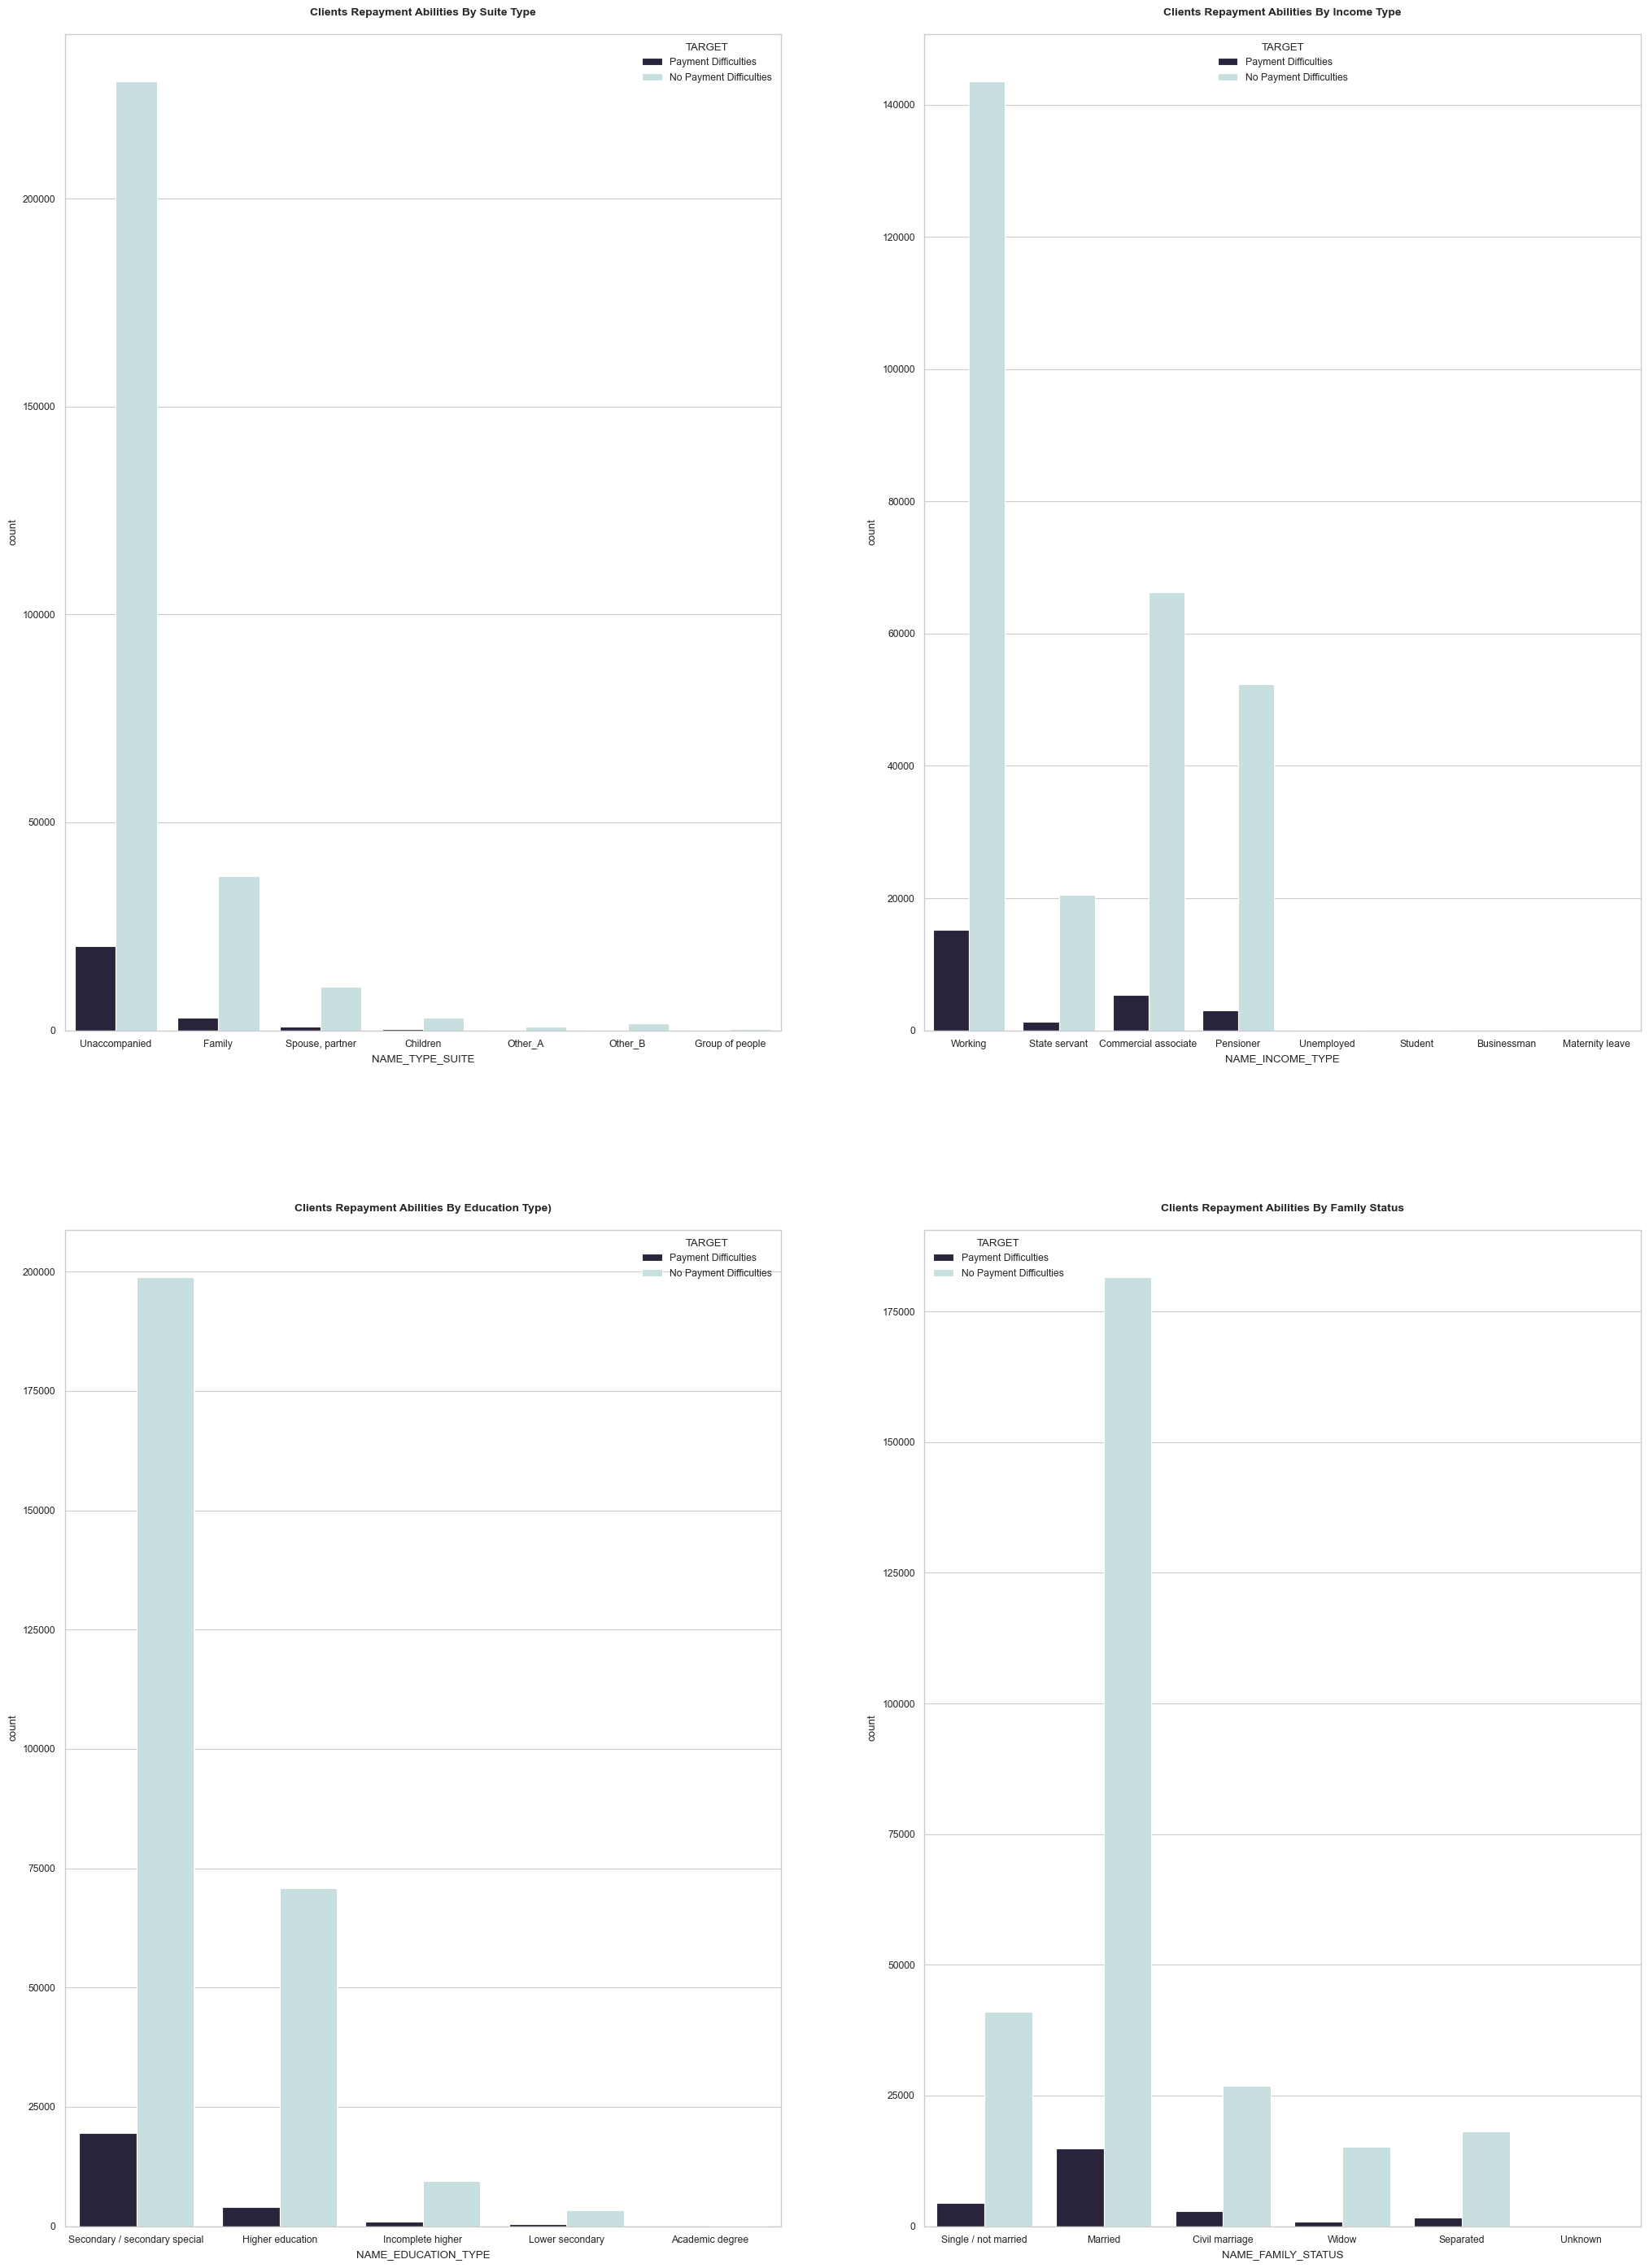

In [166]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(25,35))
sns.set_context('paper', font_scale=1)

ax[0][0].set_title('Clients Repayment Abilities By Suite Type\n', fontweight='bold', fontsize=10)
sns.countplot(x='NAME_TYPE_SUITE', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][0])

ax[0][1].set_title('Clients Repayment Abilities By Income Type\n', fontweight='bold', fontsize=10)
sns.countplot(x='NAME_INCOME_TYPE', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[0][1])

ax[1][0].set_title('\nClients Repayment Abilities By Education Type)\n', fontweight='bold', fontsize=10)
sns.countplot(x='NAME_EDUCATION_TYPE', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][0])

ax[1][1].set_title('\nClients Repayment Abilities By Family Status\n', fontweight='bold', fontsize=10)
sns.countplot(x='NAME_FAMILY_STATUS', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r', ax=ax[1][1])

##### Target vs Income Types

In [167]:
ti = df_train.groupby(by=['NAME_INCOME_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
ti.sort_values(by='SK_ID_CURR', ascending=False)
ti.style.background_gradient(cmap='Blues')

,NAME_INCOME_TYPE,TARGET,SK_ID_CURR
0,Businessman,No Payment Difficulties,10
1,Commercial associate,No Payment Difficulties,66257
2,Commercial associate,Payment Difficulties,5360
3,Maternity leave,No Payment Difficulties,3
4,Maternity leave,Payment Difficulties,2
5,Pensioner,No Payment Difficulties,52380
6,Pensioner,Payment Difficulties,2982
7,State servant,No Payment Difficulties,20454
8,State servant,Payment Difficulties,1249
9,Student,No Payment Difficulties,18


In [168]:
df[['NAME_INCOME_TYPE','TARGET']].groupby(['NAME_INCOME_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_INCOME_TYPE,TARGET
2,Maternity leave,0.400000
6,Unemployed,0.363636
7,Working,0.095885
1,Commercial associate,0.074843
4,State servant,0.057550
3,Pensioner,0.053864
0,Businessman,0.000000
5,Student,0.000000


It can be seen that the majority of customers who have a working income type have applied for loans, namely around 158,774 loan applications.

Customers with business and student income types do not experience difficulties in paying off their loans.

Meanwhile, clients with maternity leave and unemployment income types have the highest percentage of difficulty paying back loans, around 40% and 36%.

##### Target vs Education Types

In [170]:
te = df_train.groupby(by=['NAME_EDUCATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
te.sort_values(by='SK_ID_CURR', ascending=False)
te.style.background_gradient(cmap='Blues')

,NAME_EDUCATION_TYPE,TARGET,SK_ID_CURR
0,Academic degree,No Payment Difficulties,161
1,Academic degree,Payment Difficulties,3
2,Higher education,No Payment Difficulties,70854
3,Higher education,Payment Difficulties,4009
4,Incomplete higher,No Payment Difficulties,9405
5,Incomplete higher,Payment Difficulties,872
6,Lower secondary,No Payment Difficulties,3399
7,Lower secondary,Payment Difficulties,417
8,Secondary / secondary special,No Payment Difficulties,198867
9,Secondary / secondary special,Payment Difficulties,19524


In [171]:
df[['NAME_EDUCATION_TYPE','TARGET']].groupby(['NAME_EDUCATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_EDUCATION_TYPE,TARGET
3,Lower secondary,0.109277
4,Secondary / secondary special,0.089399
2,Incomplete higher,0.084850
1,Higher education,0.053551
0,Academic degree,0.018293


A total of 218K applications were submitted by medium educated clients followed by highly educated people with 75K applications.
Meanwhile, clients with lower secondary education have the highest percentage, namely 10%, and experience difficulty in paying back their loans

#####  Family Status Vs Target

In [172]:
tf = df_train.groupby(by=['NAME_FAMILY_STATUS','TARGET'], as_index=False)['SK_ID_CURR'].count()
tf.sort_values(by='SK_ID_CURR', ascending=False)
tf.style.background_gradient(cmap='Blues')

,NAME_FAMILY_STATUS,TARGET,SK_ID_CURR
0,Civil marriage,No Payment Difficulties,26814
1,Civil marriage,Payment Difficulties,2961
2,Married,No Payment Difficulties,181582
3,Married,Payment Difficulties,14850
4,Separated,No Payment Difficulties,18150
5,Separated,Payment Difficulties,1620
6,Single / not married,No Payment Difficulties,40987
7,Single / not married,Payment Difficulties,4457
8,Unknown,No Payment Difficulties,2
9,Widow,No Payment Difficulties,15151


In [173]:
df[['NAME_FAMILY_STATUS','TARGET']].groupby(['NAME_FAMILY_STATUS'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_FAMILY_STATUS,TARGET
0,Civil marriage,0.099446
3,Single / not married,0.098077
2,Separated,0.081942
1,Married,0.075599
5,Widow,0.058242
4,Unknown,0.000000


Customers who are married applied for the most loans, with 196,432 loan applications. Customers with civil marriage and single family status have the highest percentage, namely 9%, and experience problems in repaying their loans

##### Housing Type, Occupation Type, Process Day, and Organization Type

##### Housing Type Vs Target

In [174]:
th = df_train.groupby(by=['NAME_HOUSING_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
th.sort_values(by='SK_ID_CURR', ascending=False)
th.style.background_gradient(cmap='Blues')

,NAME_HOUSING_TYPE,TARGET,SK_ID_CURR
0,Co-op apartment,No Payment Difficulties,1033
1,Co-op apartment,Payment Difficulties,89
2,House / apartment,No Payment Difficulties,251596
3,House / apartment,Payment Difficulties,21272
4,Municipal apartment,No Payment Difficulties,10228
5,Municipal apartment,Payment Difficulties,955
6,Office apartment,No Payment Difficulties,2445
7,Office apartment,Payment Difficulties,172
8,Rented apartment,No Payment Difficulties,4280
9,Rented apartment,Payment Difficulties,601


In [175]:
df[['NAME_HOUSING_TYPE','TARGET']].groupby(['NAME_HOUSING_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,NAME_HOUSING_TYPE,TARGET
4,Rented apartment,0.123131
5,With parents,0.116981
2,Municipal apartment,0.085397
0,Co-op apartment,0.079323
1,House / apartment,0.077957
3,Office apartment,0.065724


Dapat dilihat bahwa nasabah dengan tipe perumahan apartemen sewaan mempunyai persentase kesulitan membayar kembali pinjamannya yang paling tinggi

Text(0.5, 0, 'Housing Type')

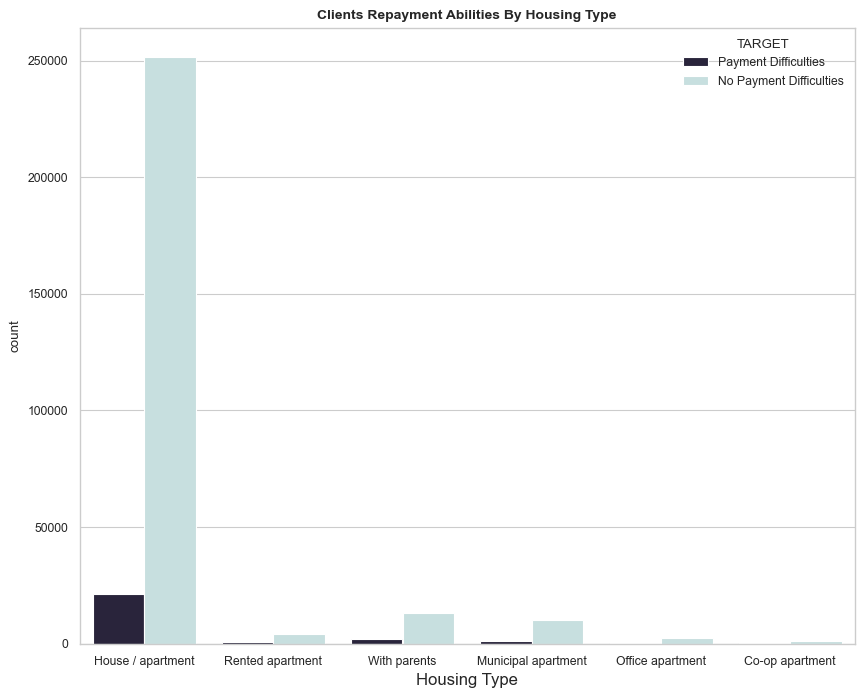

In [176]:
plt.figure(figsize=(10,8))
fig = sns.countplot(x='NAME_HOUSING_TYPE', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Housing Type', fontweight='bold', fontsize=10)
plt.xlabel('Housing Type', fontsize=12)

Klien yang tinggal di Rumah / apartemen memiliki jumlah permohonan pinjaman tertinggi sebesar 250K

##### Occupation Type Vs Target

In [177]:
to = df_train.groupby(by=['OCCUPATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
to.sort_values(by='SK_ID_CURR', ascending=False)
to.style.background_gradient(cmap='Blues')

,OCCUPATION_TYPE,TARGET,SK_ID_CURR
0,Accountants,No Payment Difficulties,9339
1,Accountants,Payment Difficulties,474
2,Cleaning staff,No Payment Difficulties,4206
3,Cleaning staff,Payment Difficulties,447
4,Cooking staff,No Payment Difficulties,5325
5,Cooking staff,Payment Difficulties,621
6,Core staff,No Payment Difficulties,25832
7,Core staff,Payment Difficulties,1738
8,Drivers,No Payment Difficulties,16496
9,Drivers,Payment Difficulties,2107


In [178]:
df[['OCCUPATION_TYPE','TARGET']].groupby(['OCCUPATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,OCCUPATION_TYPE,TARGET
9,Low-skill Laborers,0.171524
4,Drivers,0.113261
17,Waiters/barmen staff,0.112760
16,Security staff,0.107424
8,Laborers,0.105788
2,Cooking staff,0.104440
14,Sales staff,0.096318
1,Cleaning staff,0.096067
13,Realty agents,0.078562
15,Secretaries,0.070498


Banyaknya lamaran 49K diajukan oleh klien yang berprofesi sebagai Buruh. Dapat dilihat bahwa nasabah dengan jenis pekerjaan Pekerja Berketerampilan Rendah mengalami kesulitan dalam membayar kembali pinjamannya

##### Process Day Vs Target

In [180]:
tp = df_train.groupby(by=['WEEKDAY_APPR_PROCESS_START','TARGET'], as_index=False)['SK_ID_CURR'].count()
tp.sort_values(by='SK_ID_CURR', ascending=False)
tp.style.background_gradient(cmap='Blues')

,WEEKDAY_APPR_PROCESS_START,TARGET,SK_ID_CURR
0,FRIDAY,No Payment Difficulties,46237
1,FRIDAY,Payment Difficulties,4101
2,MONDAY,No Payment Difficulties,46780
3,MONDAY,Payment Difficulties,3934
4,SATURDAY,No Payment Difficulties,31182
5,SATURDAY,Payment Difficulties,2670
6,SUNDAY,No Payment Difficulties,14898
7,SUNDAY,Payment Difficulties,1283
8,THURSDAY,No Payment Difficulties,46493
9,THURSDAY,Payment Difficulties,4098


In [181]:
df[['WEEKDAY_APPR_PROCESS_START','TARGET']].groupby(['WEEKDAY_APPR_PROCESS_START'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,WEEKDAY_APPR_PROCESS_START,TARGET
5,TUESDAY,0.083505
6,WEDNESDAY,0.081604
0,FRIDAY,0.081469
4,THURSDAY,0.081003
3,SUNDAY,0.079291
2,SATURDAY,0.078873
1,MONDAY,0.077572


Text(0.5, 0, '\nProcess Day')

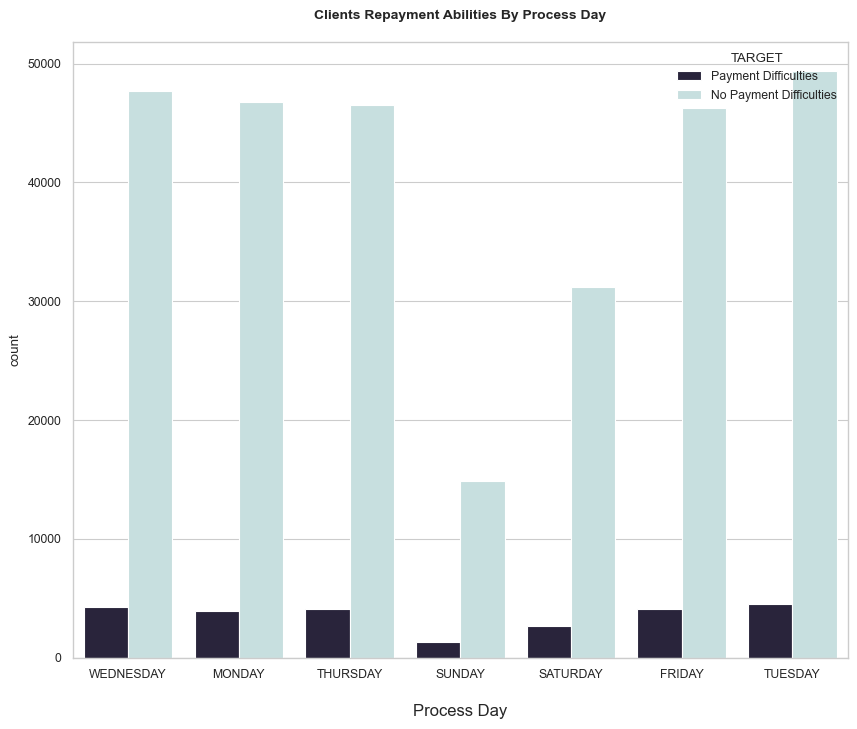

In [182]:
# visualization
plt.figure(figsize=(10,8))
fig = sns.countplot(x='WEEKDAY_APPR_PROCESS_START', data = df_train, hue = 'TARGET', palette = 'ch:start=0.2,rot=-.3_r')
plt.title('Clients Repayment Abilities By Process Day\n', fontweight='bold', fontsize=10)
plt.xlabel('\nProcess Day', fontsize=12)

##### Organization Type Vs Target

In [183]:
ot = df_train.groupby(by=['ORGANIZATION_TYPE','TARGET'], as_index=False)['SK_ID_CURR'].count()
print('Clients Repayment Abilities By Suite Type')
ot.sort_values(by='SK_ID_CURR', ascending=False)
ot.style.background_gradient(cmap='Blues')

Clients Repayment Abilities By Suite Type


,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,Advertising,No Payment Difficulties,394
1,Advertising,Payment Difficulties,35
2,Agriculture,No Payment Difficulties,2197
3,Agriculture,Payment Difficulties,257
4,Bank,No Payment Difficulties,2377
5,Bank,Payment Difficulties,130
6,Business Entity Type 1,No Payment Difficulties,5497
7,Business Entity Type 1,Payment Difficulties,487
8,Business Entity Type 2,No Payment Difficulties,9653
9,Business Entity Type 2,Payment Difficulties,900


In [184]:
df[['ORGANIZATION_TYPE','TARGET']].groupby(['ORGANIZATION_TYPE'],as_index=False).mean().sort_values(by=['TARGET'], ascending=False)

,ORGANIZATION_TYPE,TARGET
54,Transport: type 3,0.157540
18,Industry: type 13,0.134328
25,Industry: type 8,0.125000
38,Restaurant,0.117062
7,Construction,0.116798
6,Cleaning,0.111538
14,Industry: type 1,0.110683
20,Industry: type 3,0.106162
36,Realtor,0.106061
1,Agriculture,0.104727


#### Bivariate: Numerical Features Vs Target

##### Amount Credit of the Loan Vs Target

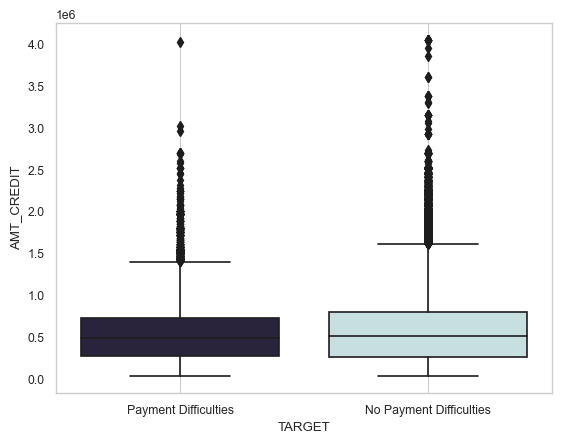

In [40]:
sns.boxplot(x='TARGET', y='AMT_CREDIT', data=df_train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

##### Amount Income Vs Target

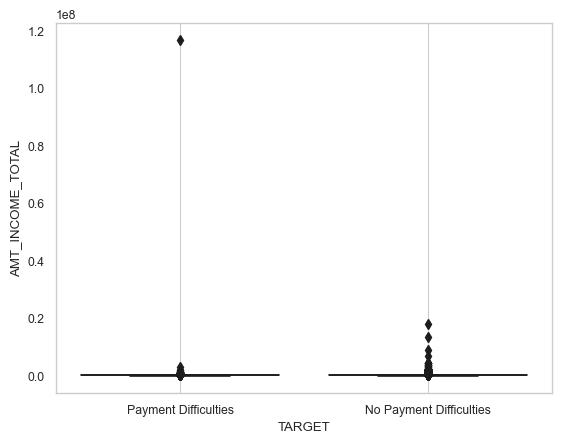

In [41]:
sns.boxplot(x='TARGET', y='AMT_INCOME_TOTAL', data=df_train, palette = 'ch:start=0.2,rot=-.3_r')
plt.grid()
plt.show()

##### Age Vs target

In [42]:
no_age = df[df['TARGET']==0]['DAYS_BIRTH'].values/-365
yes_age = df[df['TARGET']==1]['DAYS_BIRTH'].values/-365

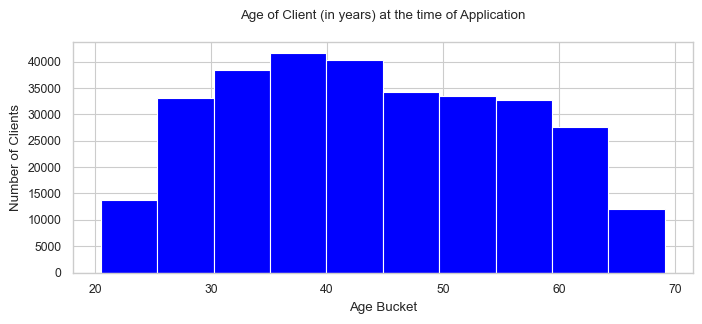

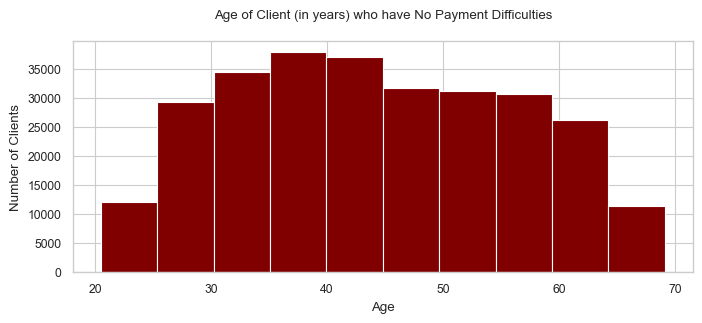

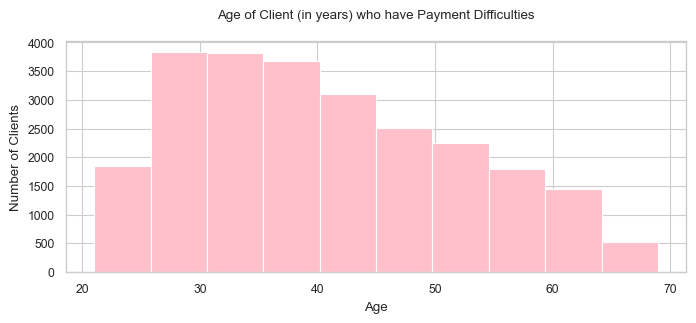

In [185]:
plt.figure(figsize=(8,3))
plt.hist(df['DAYS_BIRTH'].values/-365, bins=10, color='blue')
plt.title('Age of Client (in years) at the time of Application\n')
plt.xlabel('Age Bucket')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(8,3))
plt.hist(no_age, bins=10, color='maroon')
plt.title('Age of Client (in years) who have No Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

plt.figure(figsize=(8,3))
plt.hist(yes_age, bins=10, color='pink')
plt.title('Age of Client (in years) who have Payment Difficulties\n')
plt.xlabel('Age')
plt.ylabel('Number of Clients')
plt.show()

Jumlah nasabah yang mengajukan pinjaman terbanyak berada pada rentang usia 35-40 tahun, disusul nasabah pada rentang usia 40-45 tahun. Sementara itu, jumlah pelamar untuk klien berusia kurang dari 25 atau lebih dari 65 tahun sangat sedikit. Klien yang tidak mengalami kesulitan pembayaran adalah klien rentang 35-45 tahun. Sedangkan klien yang mengalami kesulitan pembayaran adalah klien rentang 25-35 tahun

##### Grouped by Realty Ownership Status

a. Car Ownership Status, The Number of Children, Target, and House/Flat Ownership Status

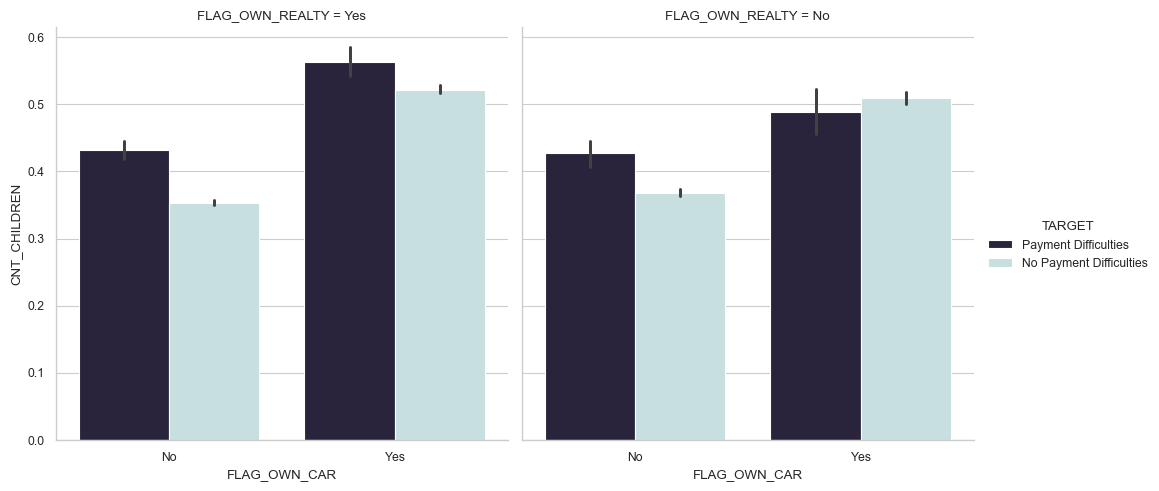

In [44]:
sns.catplot(x = 'FLAG_OWN_CAR',
            y = 'CNT_CHILDREN', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)
plt.show()

b. Income Type, Amount of Goods Price, Target, and House/Flat Ownership Status

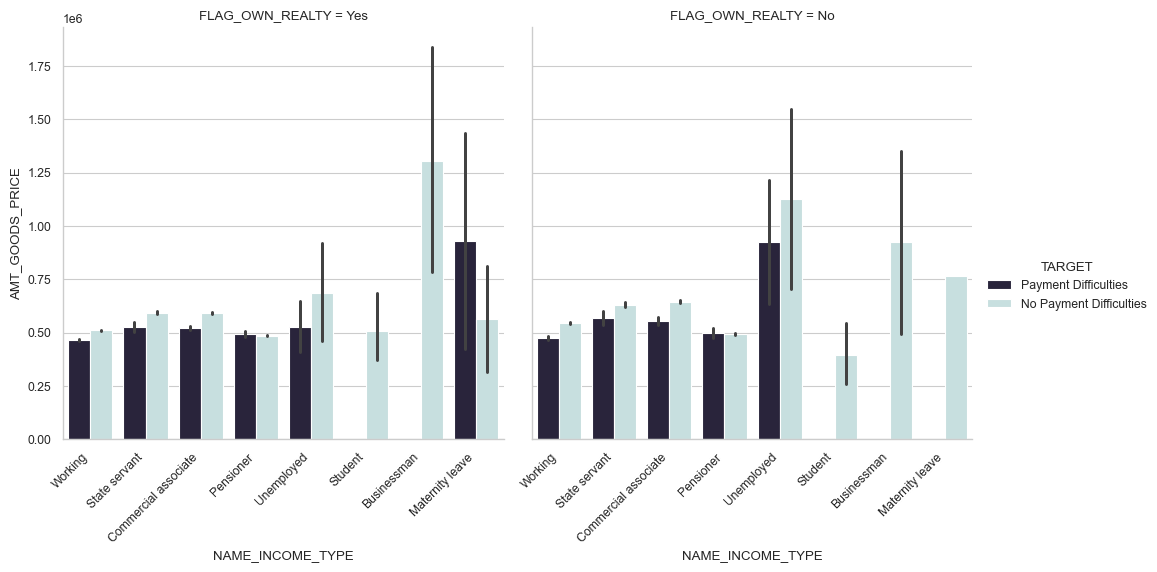

In [45]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_GOODS_PRICE', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

c. Family Status, Amount of Income, Target, and House/Flat Ownership Status

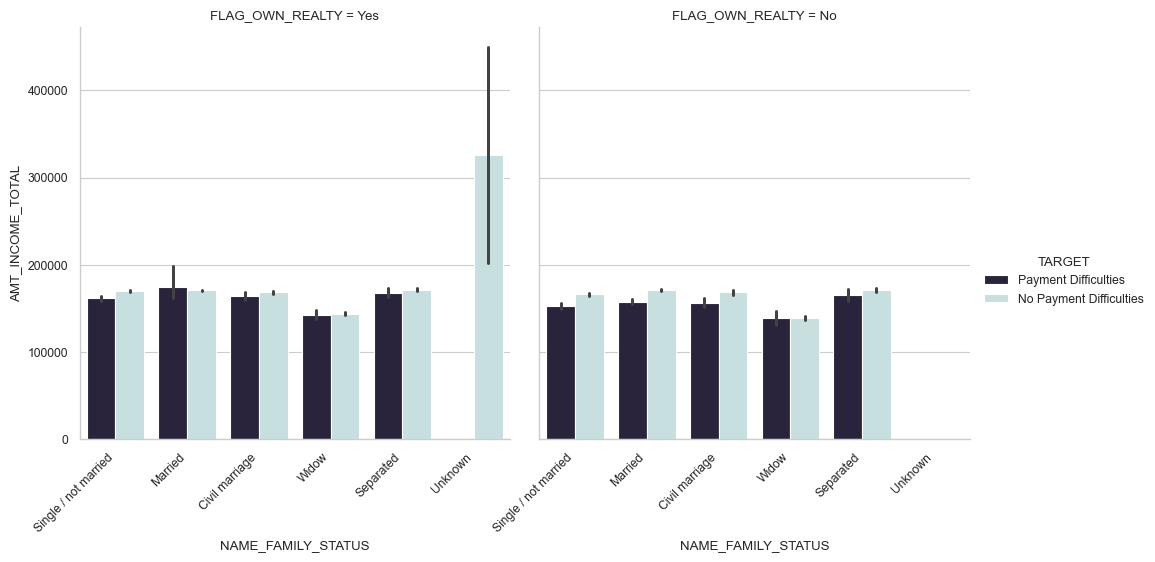

In [46]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_INCOME_TOTAL', 
            hue = 'TARGET', 
            col = 'FLAG_OWN_REALTY', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

In [47]:
#train.groupby(by=['NAME_FAMILY_STATUS','FLAG_OWN_REALTY', 'TARGET'], as_index=False)['AMT_INCOME_TOTAL'].mean()

##### Grouped by Contract Type

a. Income Type, Amount of Credit, Target, and Contract Type

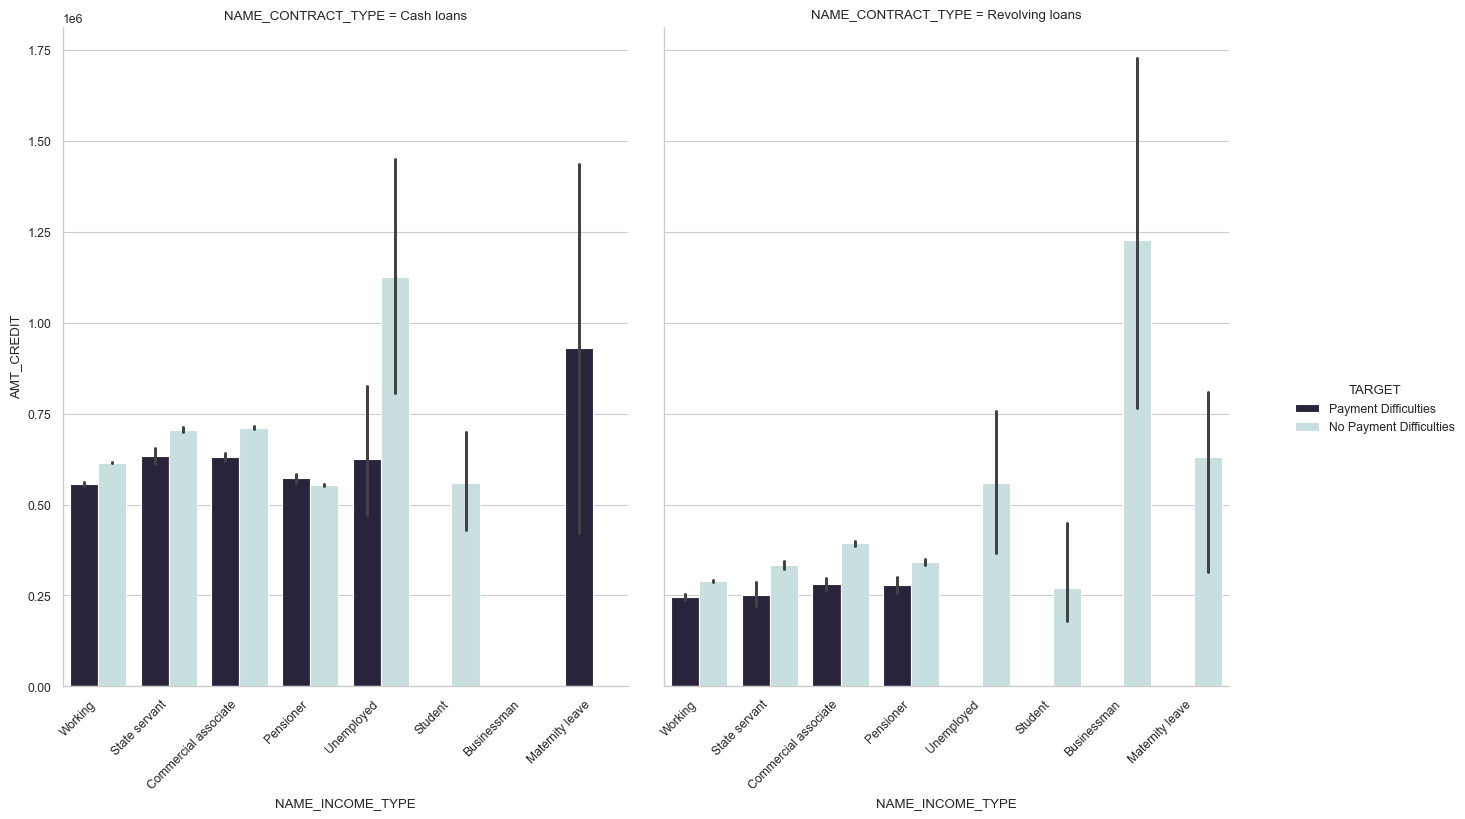

In [49]:
fig = sns.catplot(x = 'NAME_INCOME_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'NAME_CONTRACT_TYPE', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(15, 8)
plt.show()

##### Grouped by Rating of Region where Client Lives

a. Housing Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

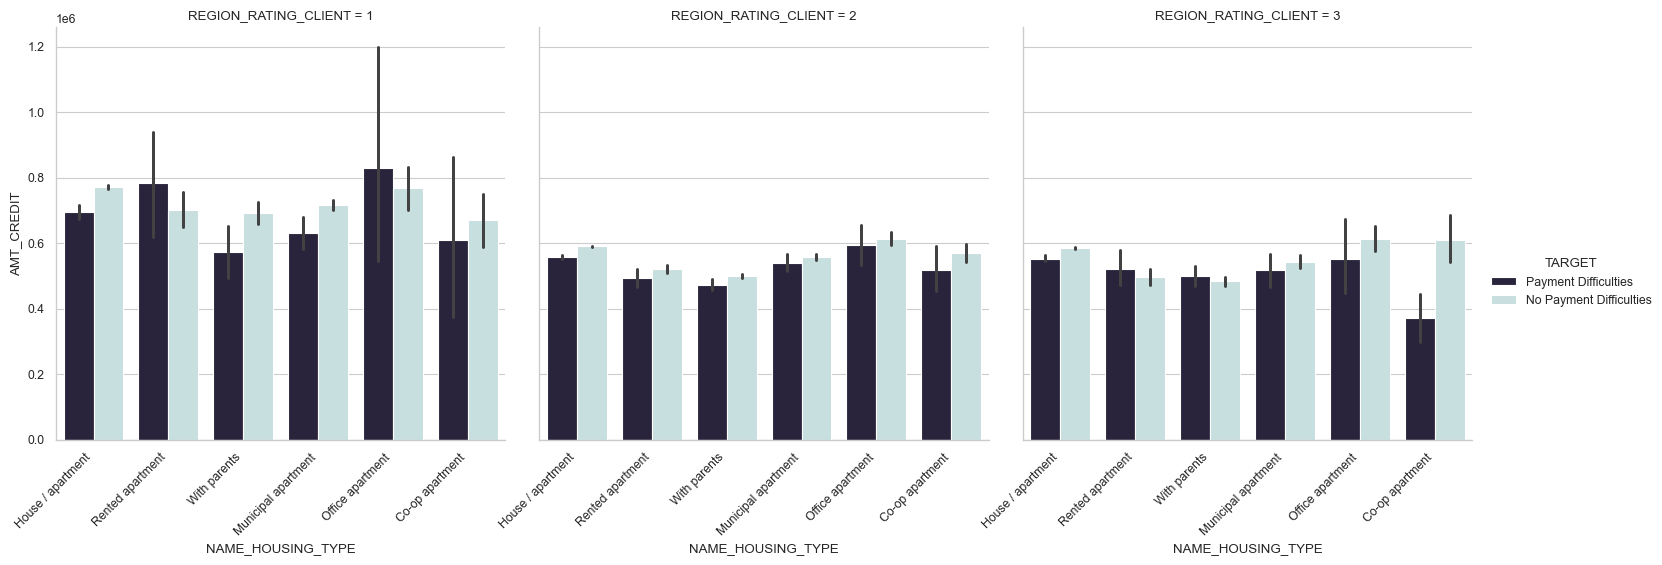

In [51]:
fig = sns.catplot(x = 'NAME_HOUSING_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

b. Education Type, Amount Credit of Loan, Target, and Rating of Region where Client Lives

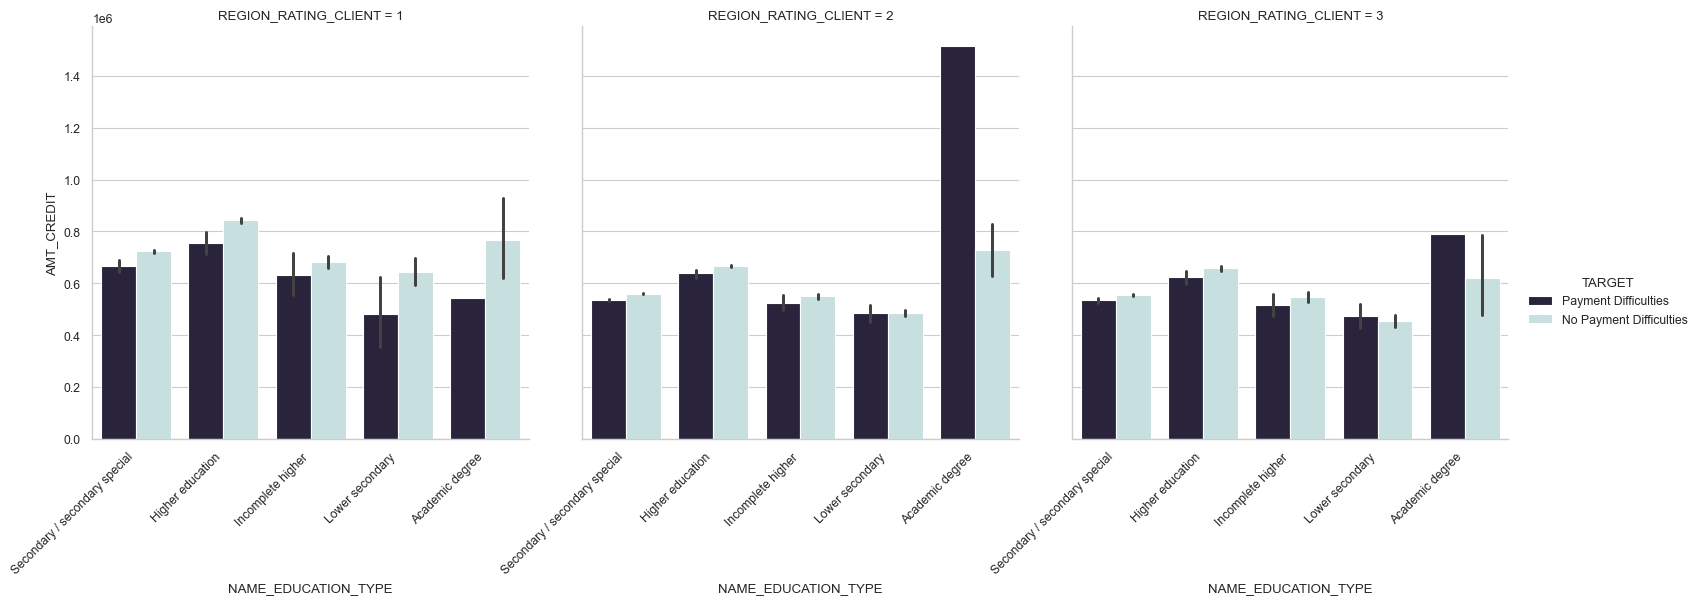

In [52]:
fig = sns.catplot(x = 'NAME_EDUCATION_TYPE',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

c. Family Status, Amount Credit of Loan, Target, and Rating of Region where Client Lives

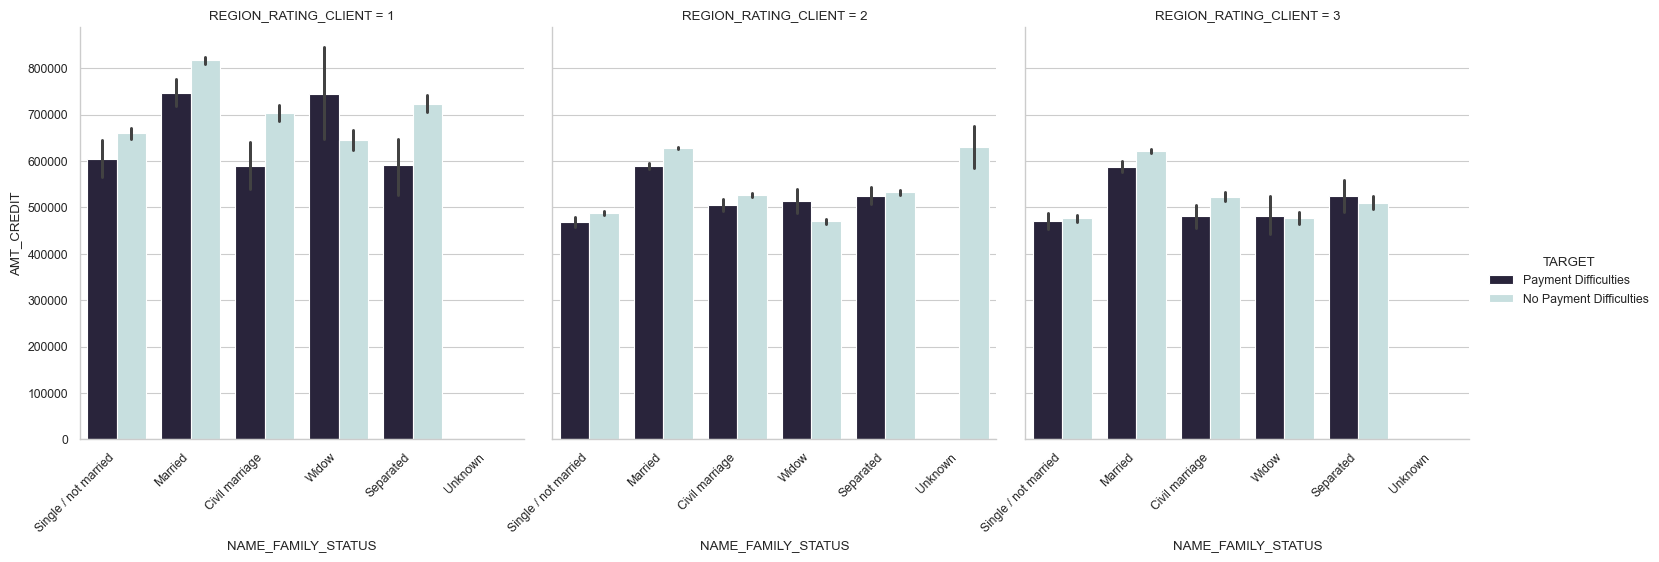

In [53]:
fig = sns.catplot(x = 'NAME_FAMILY_STATUS',
            y = 'AMT_CREDIT', 
            hue = 'TARGET', 
            col = 'REGION_RATING_CLIENT', 
            kind = 'bar', palette = 'ch:start=0.2,rot=-.3_r',
            data = df_train)

fig.set_xticklabels(rotation=45, horizontalalignment='right')
plt.show()

## Data Cleaning

### Detecting Data Duplication

In [186]:
print('Count of duplication is:', df.duplicated().sum())

Count of duplication is: 0


### Detecting Missing Values

In [187]:
print('Missing values status:', df.isnull().values.any())
mv = pd.DataFrame(df.isnull().sum(), columns=['Total Null Values'])
mv['Percentage'] = (nvc['Total Null Values']/df.shape[0])*100
mv.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_CITY_NOT_WORK_CITY,0,0.0
2,FLAG_DOCUMENT_8,0,0.0
3,FLAG_DOCUMENT_7,0,0.0
4,FLAG_DOCUMENT_6,0,0.0
5,FLAG_DOCUMENT_5,0,0.0
6,FLAG_DOCUMENT_4,0,0.0
7,FLAG_DOCUMENT_3,0,0.0
8,FLAG_DOCUMENT_2,0,0.0
9,DAYS_LAST_PHONE_CHANGE,1,0.0


In [188]:
df.drop(df_train.iloc[:, 44:91], inplace=True, axis=1)
df.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [189]:
print('Missing values status:', df_train.isnull().values.any())
mv= pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
mv['Percentage'] = (nvc['Total Null Values']/df.shape[0])*100
mv.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: True


,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,DAYS_REGISTRATION,0,0.0
2,FLAG_OWN_REALTY,0,0.0
3,TARGET,0,0.0
4,FLAG_EMAIL,0,0.0
5,FLAG_PHONE,0,0.0
6,FLAG_CONT_MOBILE,0,0.0
7,NAME_CONTRACT_TYPE,0,0.0
8,FLAG_WORK_PHONE,0,0.0
9,FLAG_EMP_PHONE,0,0.0


C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='AMT_REQ_CREDIT_BUREAU_DAY', ylabel='Density'>

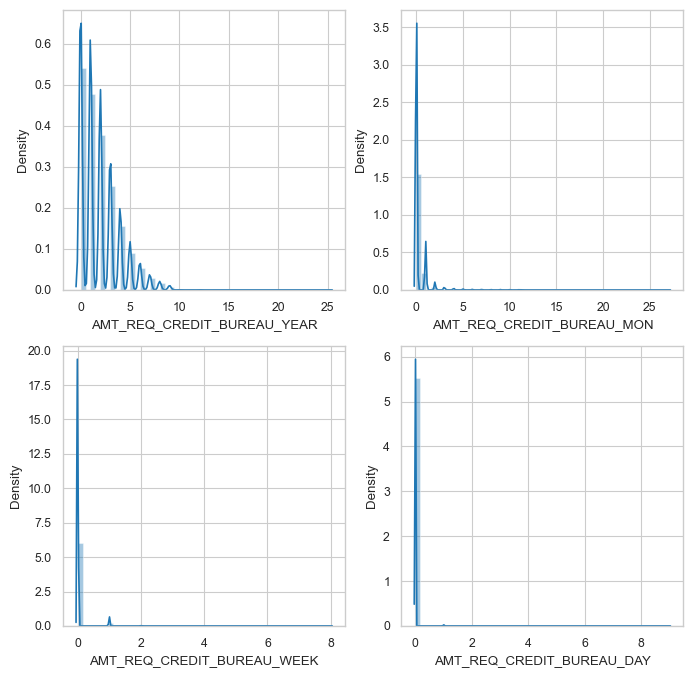

In [190]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(8,8))
sns.set_context('paper', font_scale=1)

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_YEAR'], ax=ax[0][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_MON'], ax=ax[0][1])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_WEEK'], ax=ax[1][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_DAY'], ax=ax[1][1])

C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='AMT_ANNUITY', ylabel='Density'>

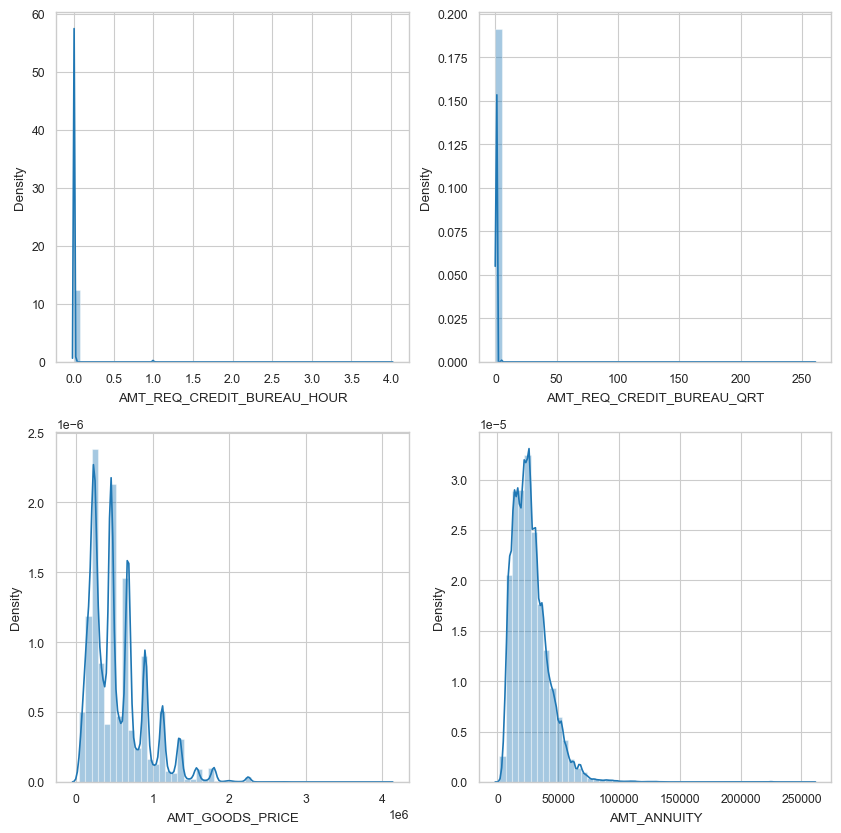

In [60]:
# distribution of numerical features that have missing values pt.2
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_HOUR'], ax=ax[0][0])

sns.distplot(df['AMT_REQ_CREDIT_BUREAU_QRT'], ax=ax[0][1])

sns.distplot(df['AMT_GOODS_PRICE'], ax=ax[1][0])

sns.distplot(df['AMT_ANNUITY'], ax=ax[1][1])

C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-

<AxesSubplot:xlabel='OBS_30_CNT_SOCIAL_CIRCLE', ylabel='Density'>

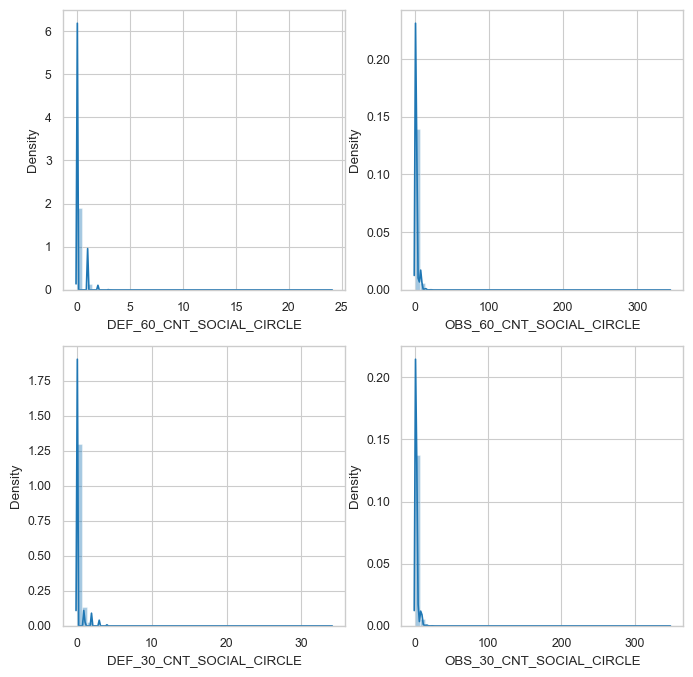

In [191]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2,2, figsize=(8,8))
sns.set_context('paper', font_scale=1)

sns.distplot(df['DEF_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][0])

sns.distplot(df['OBS_60_CNT_SOCIAL_CIRCLE'], ax=ax[0][1])

sns.distplot(df['DEF_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][0])

sns.distplot(df['OBS_30_CNT_SOCIAL_CIRCLE'], ax=ax[1][1])

C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\garini\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DAYS_LAST_PHONE_CHANGE', ylabel='Density'>

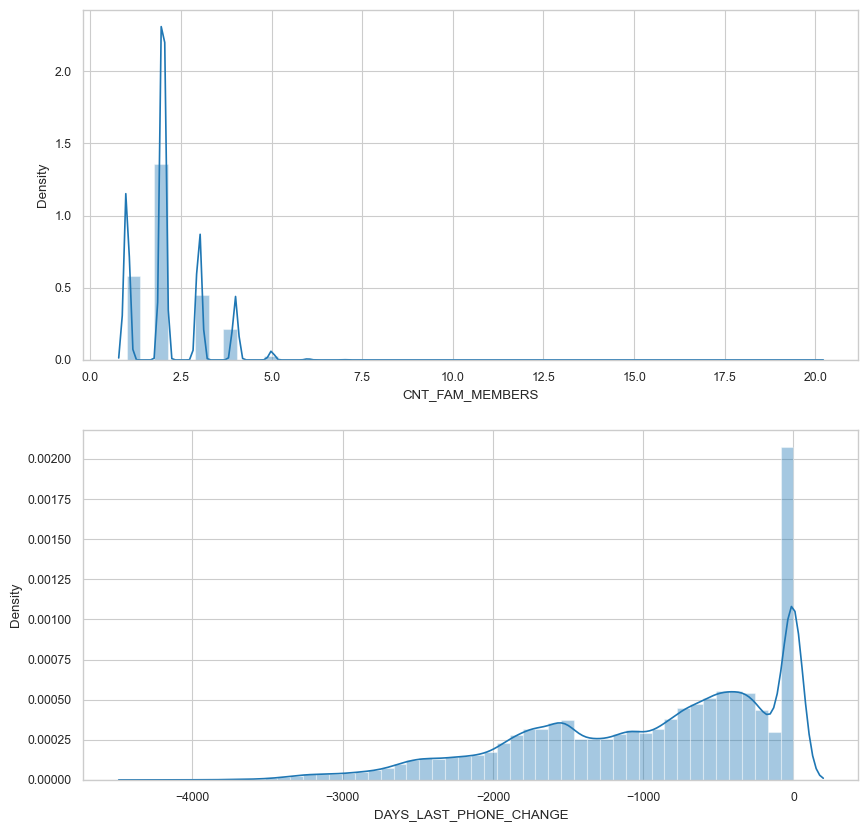

In [62]:
# distribution of numerical features that have missing values pt.3
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, figsize=(10,10))
sns.set_context('paper', font_scale=1)

sns.distplot(df['CNT_FAM_MEMBERS'], ax=ax[0])

sns.distplot(df['DAYS_LAST_PHONE_CHANGE'], ax=ax[1])

In [192]:
category_columns = df.select_dtypes(include=['object']).columns.tolist()
integer_columns = df.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df:
    if df[column].isnull().any():
        if(column in category_columns):
            df[column]=df[column].fillna(df[column].mode()[0])
        else:
            df[column]=df[column].fillna(df[column].median())

In [193]:
print('Missing values status:', df.isnull().values.any())
print('\nThe number of missing values for each columns (after imputation): \n')
mv = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
mv['Percentage'] = (mv['Total Null Values']/df.shape[0])*100
mv.sort_values(by=['Percentage'], ascending=False).reset_index()

Missing values status: False

The number of missing values for each columns (after imputation): 



,index,Total Null Values,Percentage
0,SK_ID_CURR,0,0.0
1,REG_REGION_NOT_WORK_REGION,0,0.0
2,REGION_POPULATION_RELATIVE,0,0.0
3,AMT_INCOME_TOTAL,0,0.0
4,TARGET,0,0.0
5,NAME_CONTRACT_TYPE,0,0.0
6,CODE_GENDER,0,0.0
7,FLAG_OWN_CAR,0,0.0
8,FLAG_OWN_REALTY,0,0.0
9,CNT_CHILDREN,0,0.0


### Detecting Outliers

In [65]:
int_features = df[["CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "AMT_GOODS_PRICE"]]

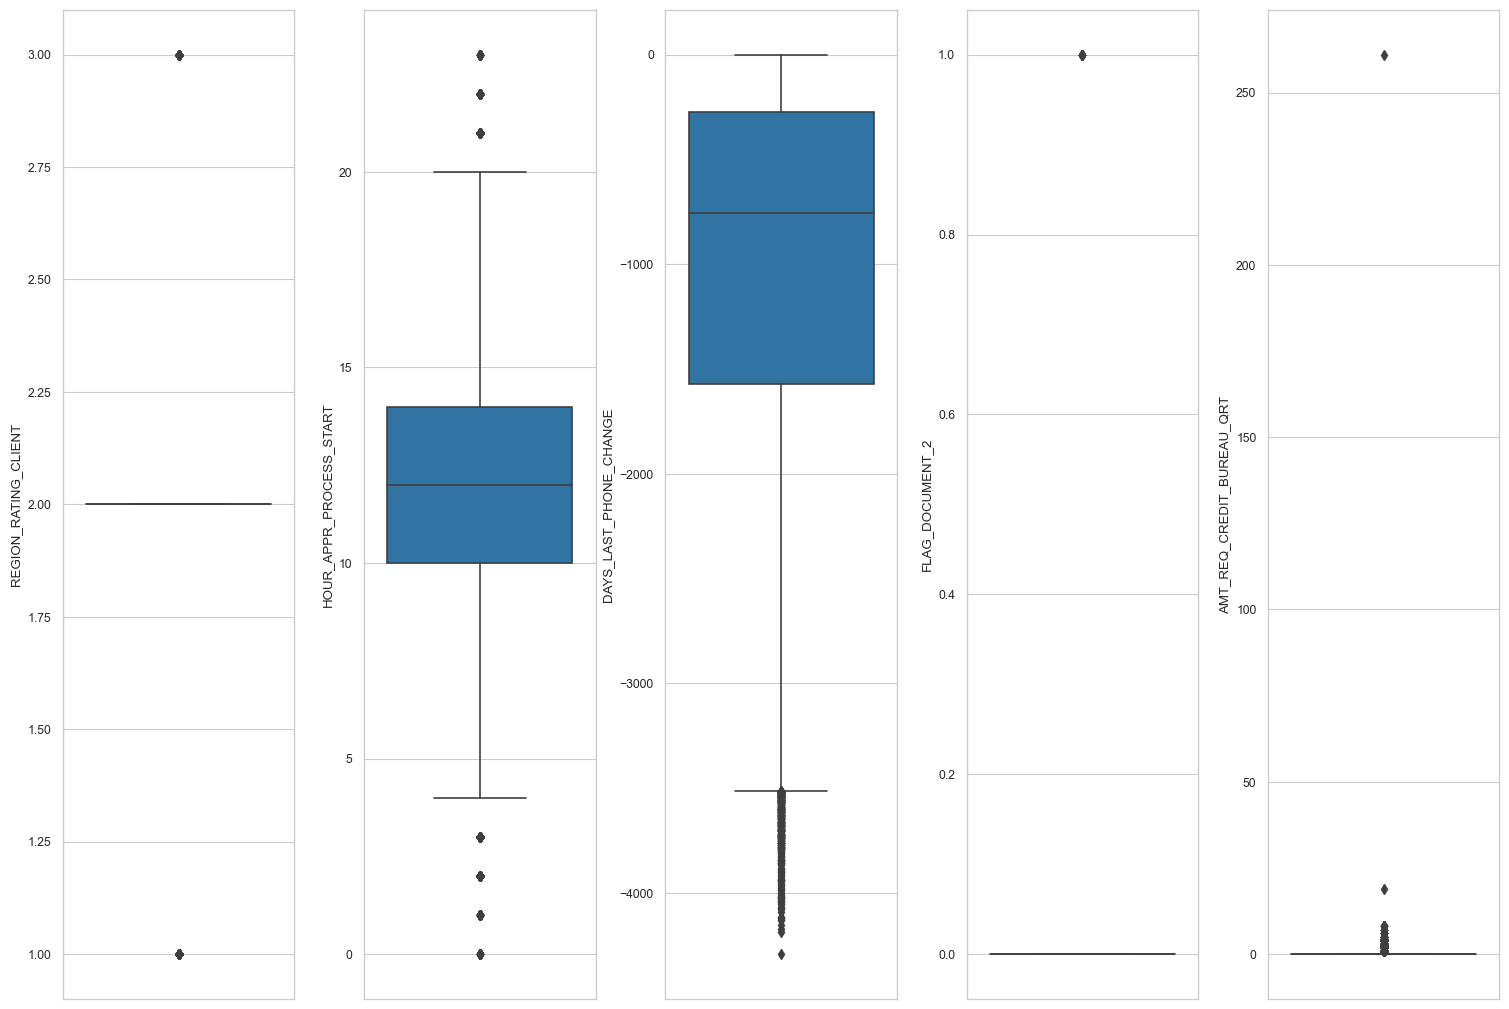

In [194]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [195]:
int_features = df[["DAYS_BIRTH", "DAYS_EMPLOYED", "DAYS_REGISTRATION", "DAYS_ID_PUBLISH", "CNT_FAM_MEMBERS"]]

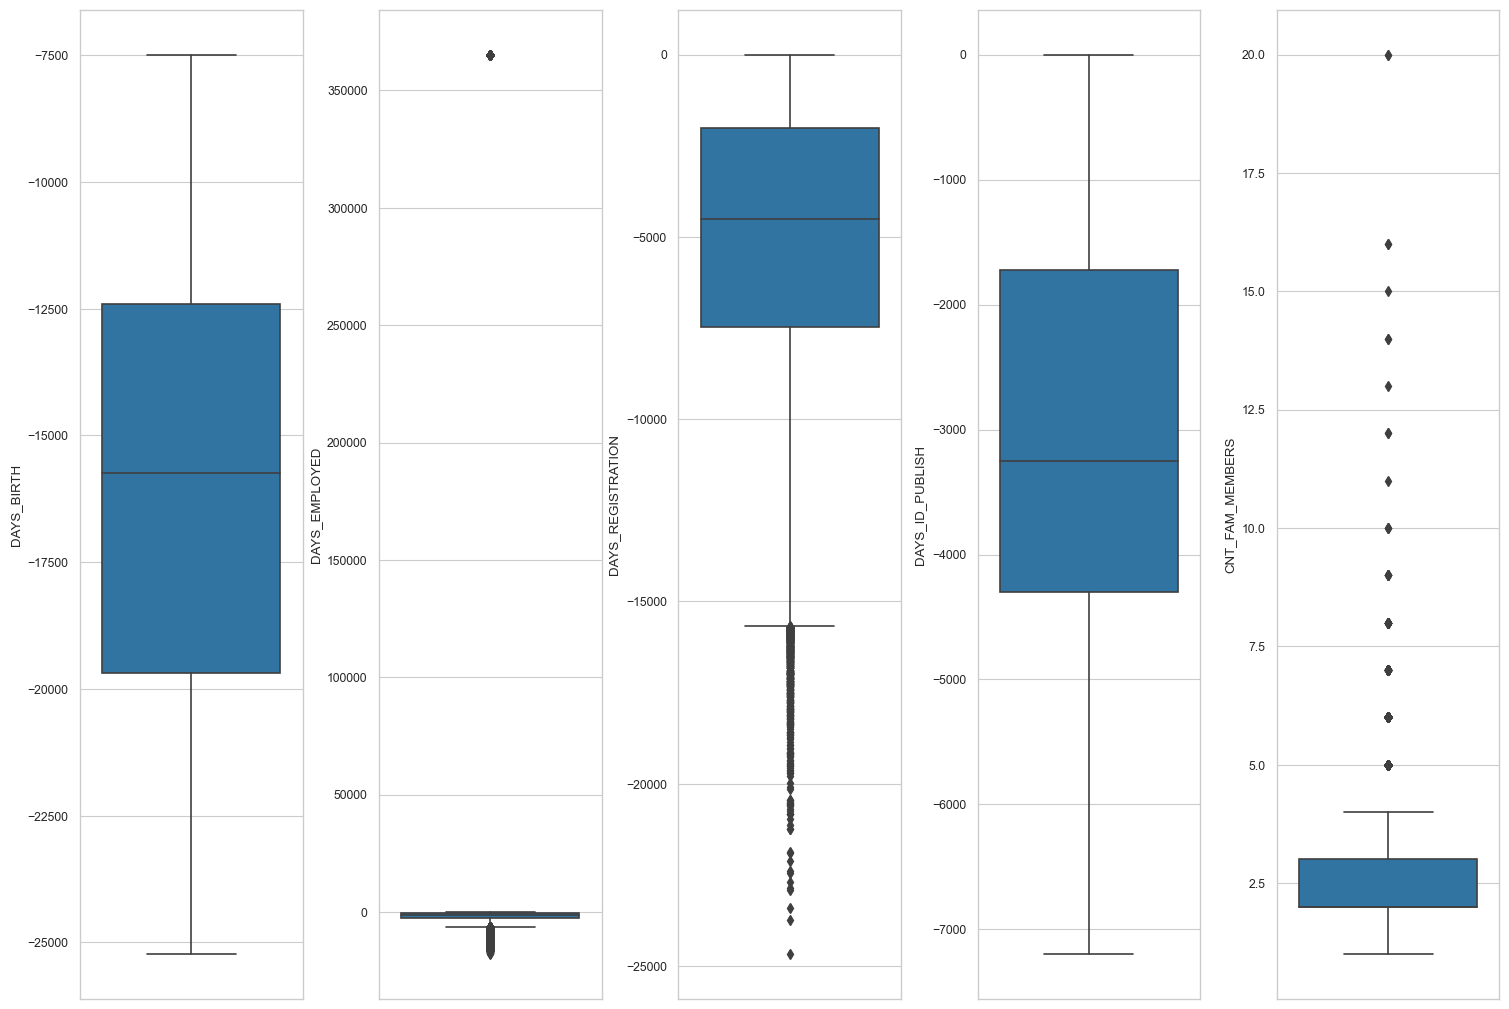

In [196]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [197]:
int_features = df[["AMT_REQ_CREDIT_BUREAU_YEAR", "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_WEEK", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_HOUR"]]

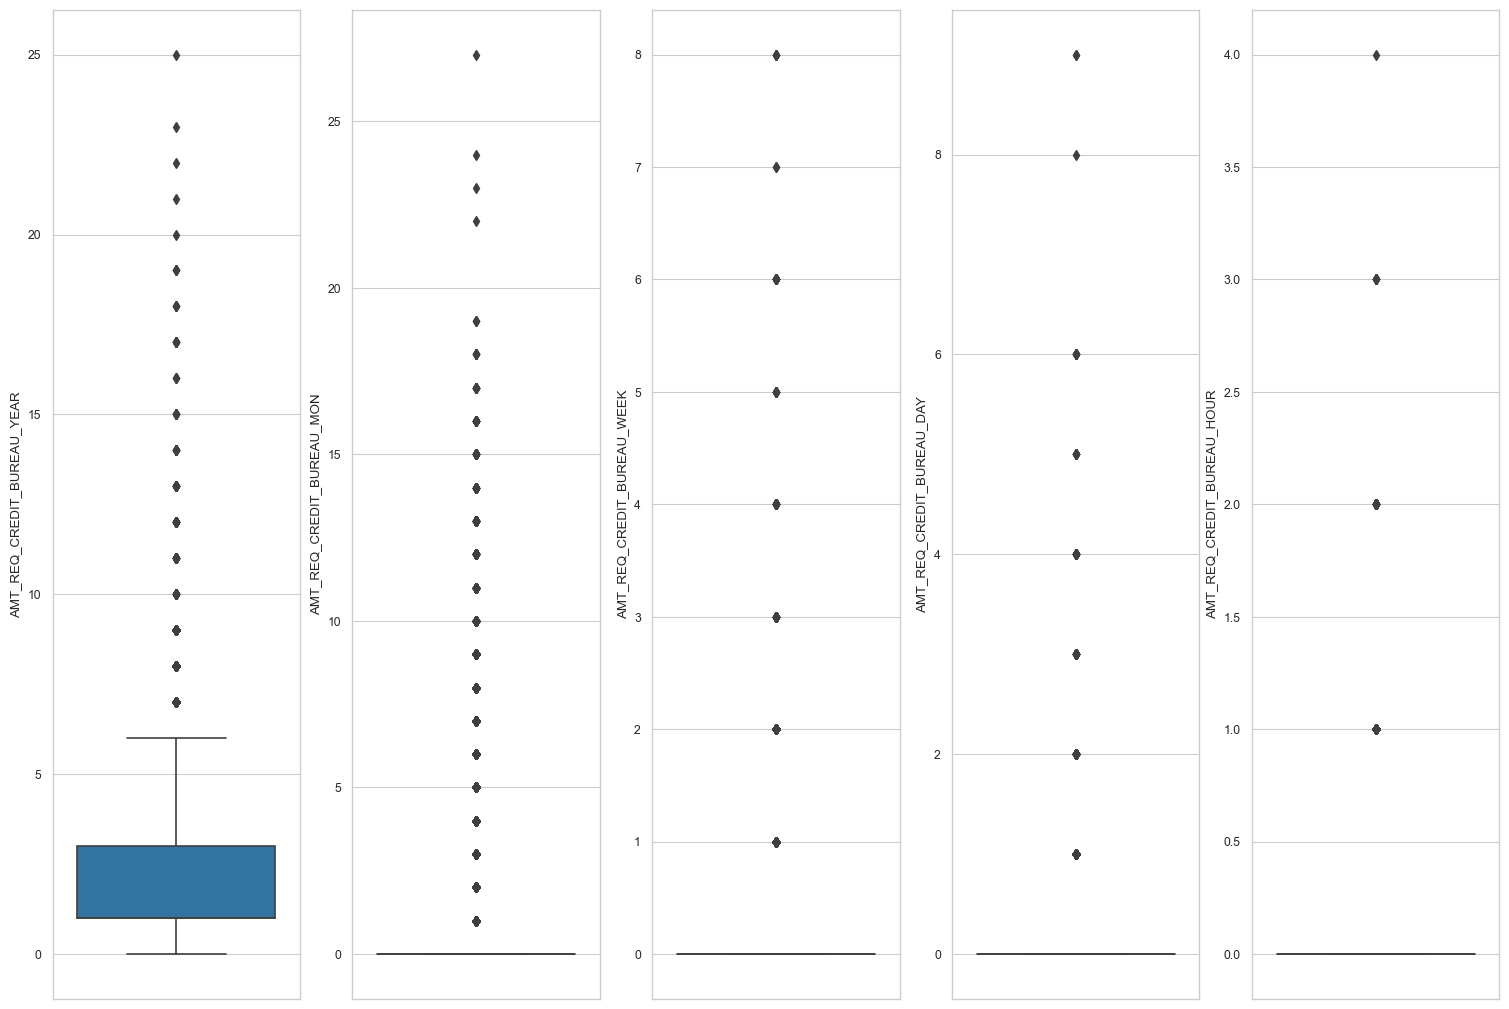

In [198]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15,10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [199]:
int_features = df[["OBS_30_CNT_SOCIAL_CIRCLE", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_30_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "REGION_POPULATION_RELATIVE"]]

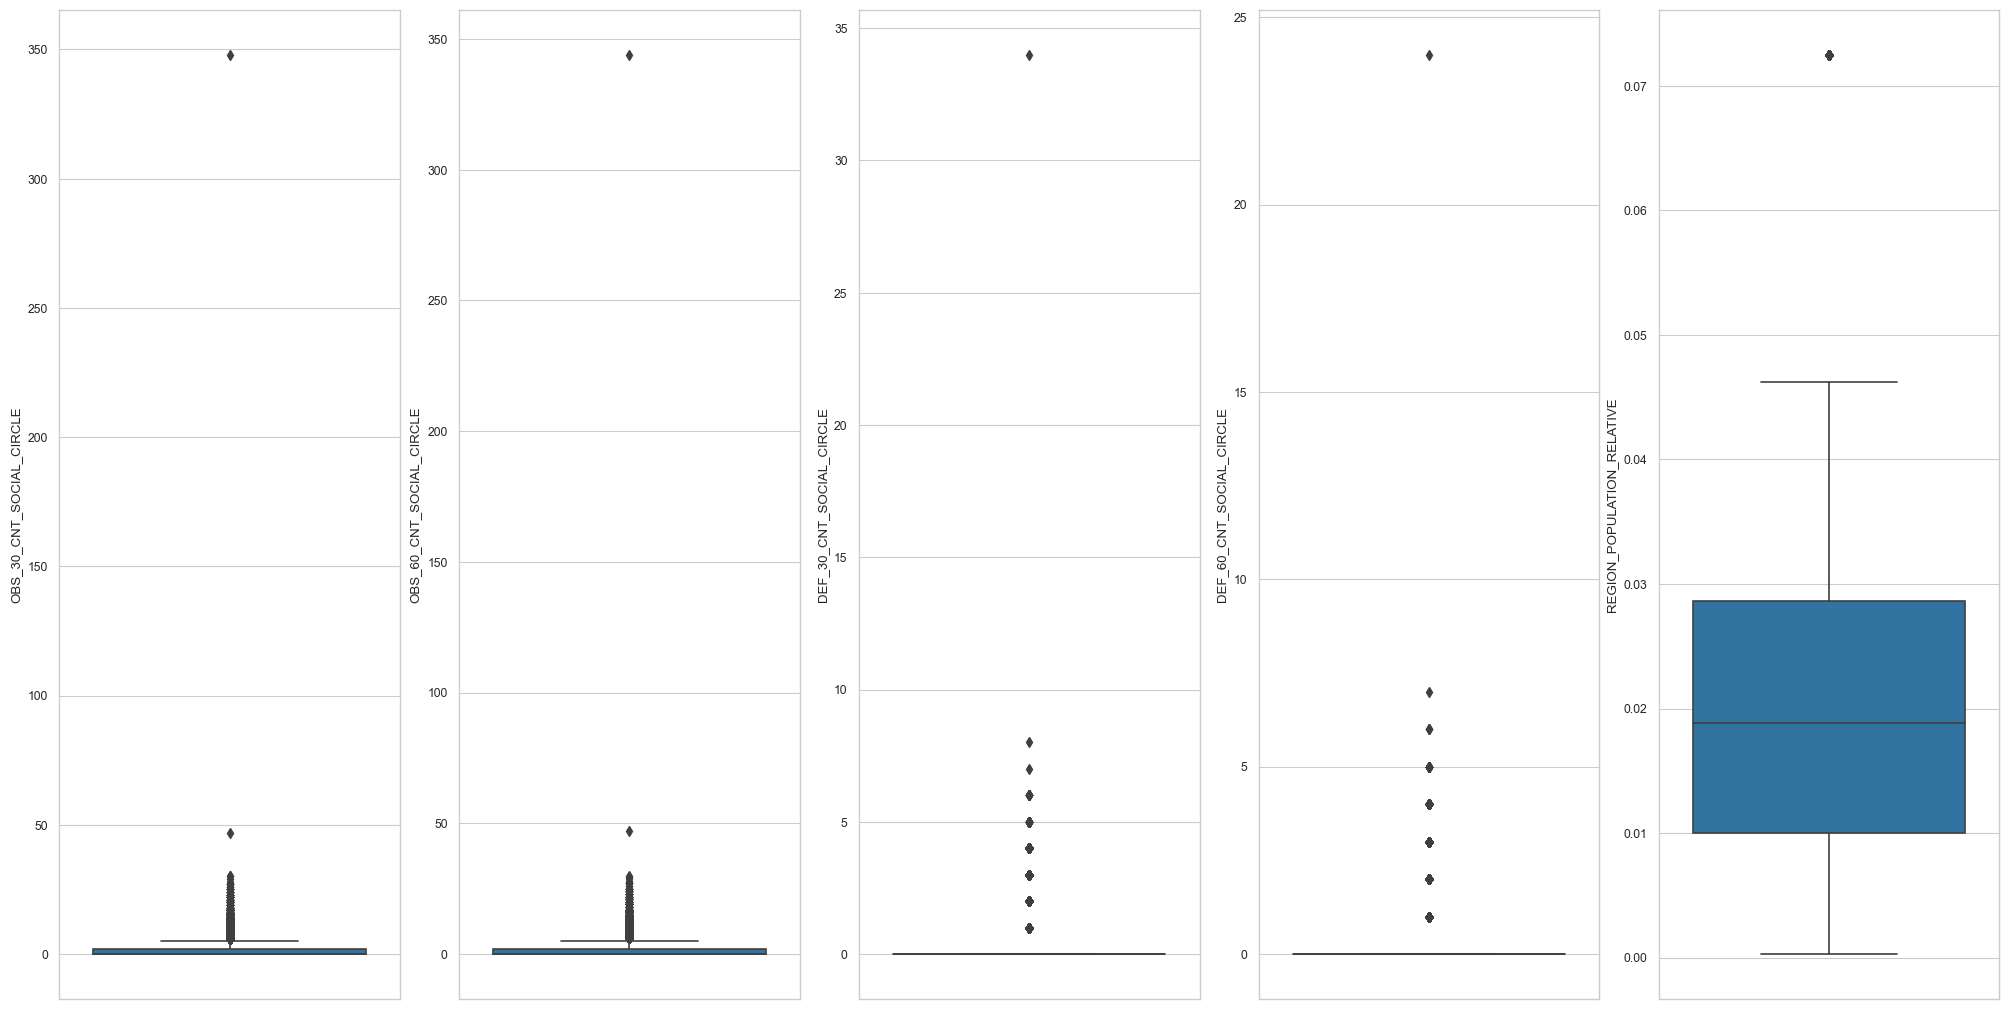

In [72]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [200]:
int_features = df[["REGION_RATING_CLIENT", "HOUR_APPR_PROCESS_START", "DAYS_LAST_PHONE_CHANGE", "FLAG_DOCUMENT_2", "AMT_REQ_CREDIT_BUREAU_QRT"]]

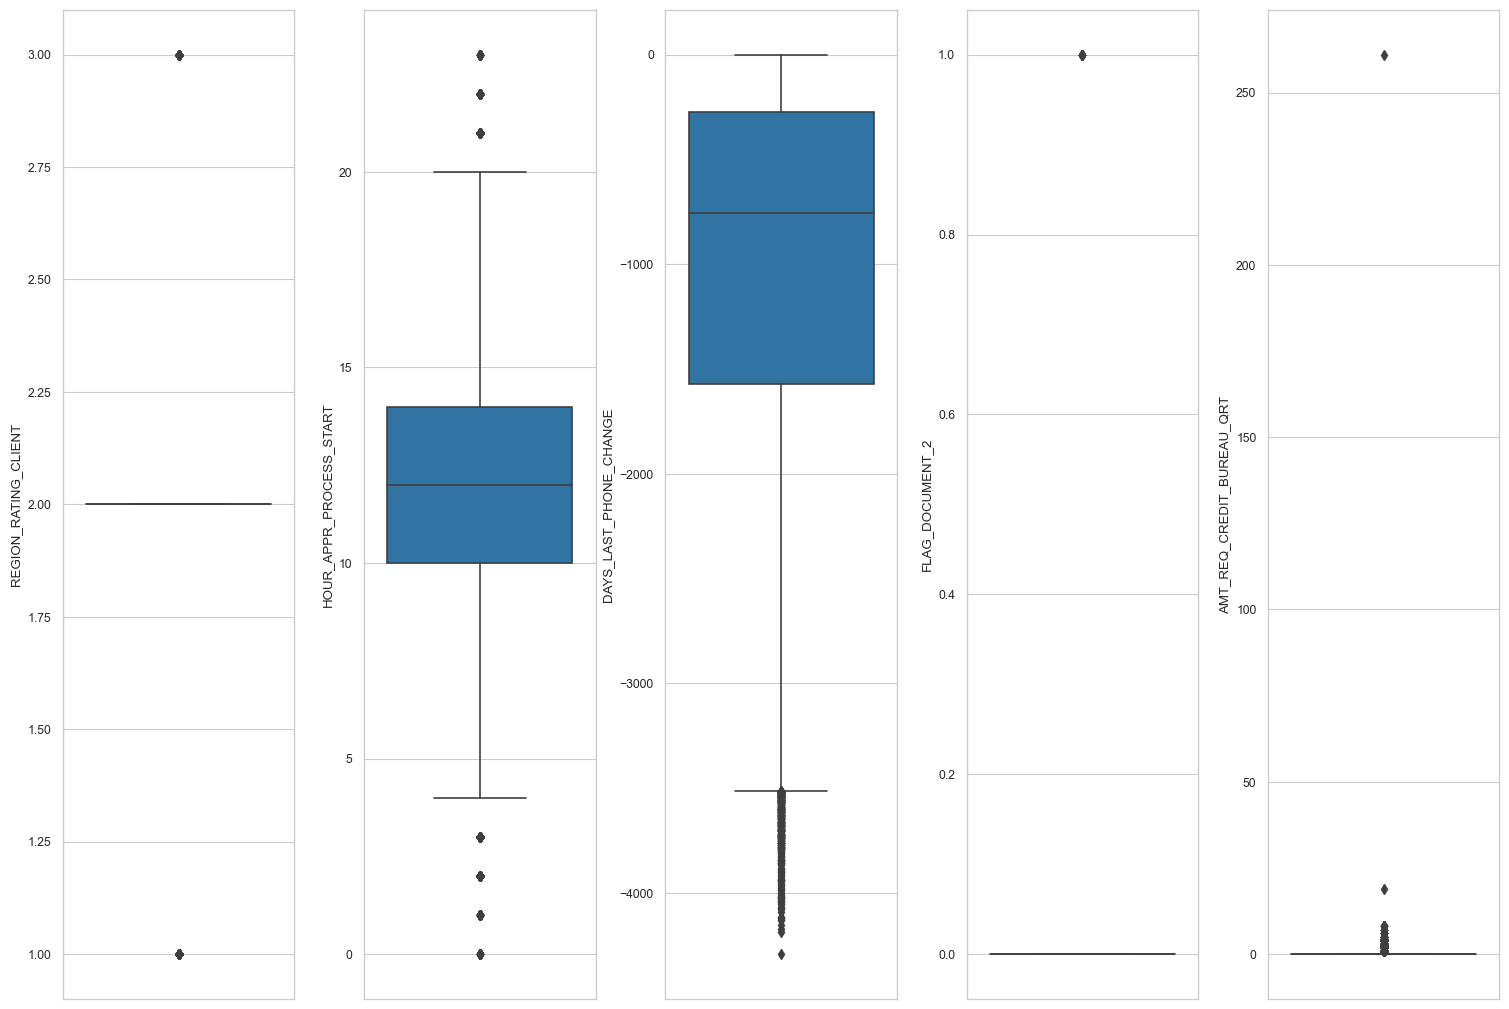

In [201]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(15,10))
index = 0
axs = axs.flatten()
for k,v in int_features.items():
    sns.boxplot(y = k, data = int_features, ax=axs[index])
    index += 1
    if index == 5:
      break;
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Models Machine Learning

### Label Encoding

In [202]:
df[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [203]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature Selection

In [204]:
df.drop(['SK_ID_CURR'], inplace=True, axis=1)

In [205]:
df.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,0.262949,0.139376,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,0.622246,0.535276,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,0.555912,0.729567,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,0.650442,0.535276,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,0.322738,0.535276,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [206]:
df.iloc[:,16:20] = df.iloc[:,16:20].abs()
df.iloc[:,45] = df.iloc[:,45].abs()

In [207]:
x = df.drop(['TARGET'], axis=1)
y = df['TARGET']

In [81]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Features', 'Score']
print('The features that correlate well with target feature:\n')
featureScores.sort_values(by=['Score'], ascending=False)

The features that correlate well with target feature:



,Features,Score
16,DAYS_EMPLOYED,1.954124e+08
8,AMT_GOODS_PRICE,1.223080e+08
6,AMT_CREDIT,7.669987e+07
15,DAYS_BIRTH,2.235391e+06
5,AMT_INCOME_TOTAL,1.624102e+06
17,DAYS_REGISTRATION,1.348566e+06
44,DAYS_LAST_PHONE_CHANGE,6.656876e+05
18,DAYS_ID_PUBLISH,6.195946e+05
7,AMT_ANNUITY,3.913092e+05
37,ORGANIZATION_TYPE,4.138607e+03


### Handling Data Imbalance

In [208]:
df_majority = df[(df['TARGET']==0)] 
df_minority = df[(df['TARGET']==1)] 

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    
                                 n_samples= 282686, 
                                 random_state=42) 


df_upsampled = pd.concat([df_minority_upsampled, df_majority])

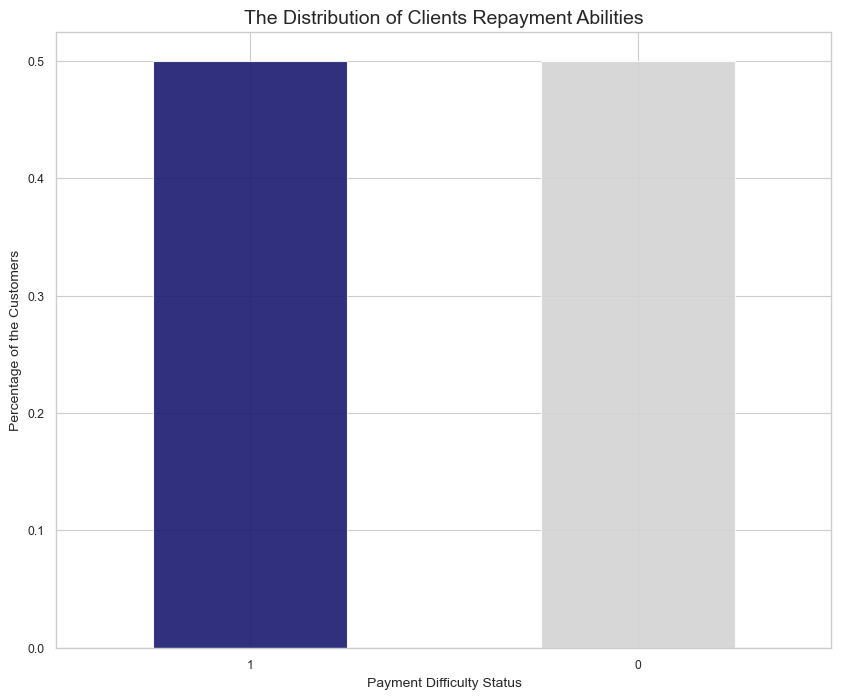

In [209]:
fig = plt.figure(figsize = (10,8))
df_upsampled['TARGET'].value_counts(normalize=True).plot(kind='bar', color= ['midnightblue','lightgrey'], alpha = 0.9, rot=0)
plt.title('The Distribution of Clients Repayment Abilities', fontsize=14)
plt.ylabel('Percentage of the Customers', fontsize=10)
plt.xlabel('Payment Difficulty Status', fontsize=10)
plt.show()

### **Data Splitting**

In [210]:
x_balanced = df_upsampled[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
y_balanced = df_upsampled['TARGET']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(452297, 20) (113075, 20)


In [215]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Model Building

#### Logistic Regression

In [213]:
log_mod = LogisticRegression().fit(X_train, y_train)
print(log_mod)

LogisticRegression()


In [216]:
y_train_pred_log = log_mod.predict(X_train)
print(classification_report(y_train, y_train_pred_log))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68    226185
           1       0.68      0.66      0.67    226112

    accuracy                           0.67    452297
   macro avg       0.67      0.67      0.67    452297
weighted avg       0.67      0.67      0.67    452297



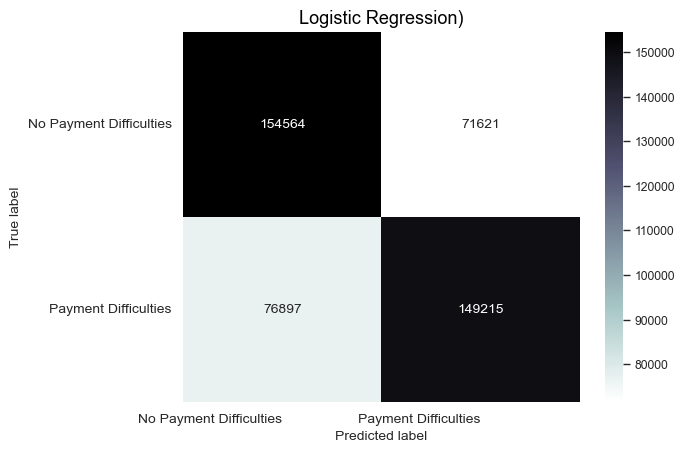

In [217]:
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_train, y_train_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Logistic Regression)', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [218]:
y_test_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_test_pred_log))

              precision    recall  f1-score   support

           0       0.67      0.68      0.68     56501
           1       0.68      0.66      0.67     56574

    accuracy                           0.67    113075
   macro avg       0.67      0.67      0.67    113075
weighted avg       0.67      0.67      0.67    113075



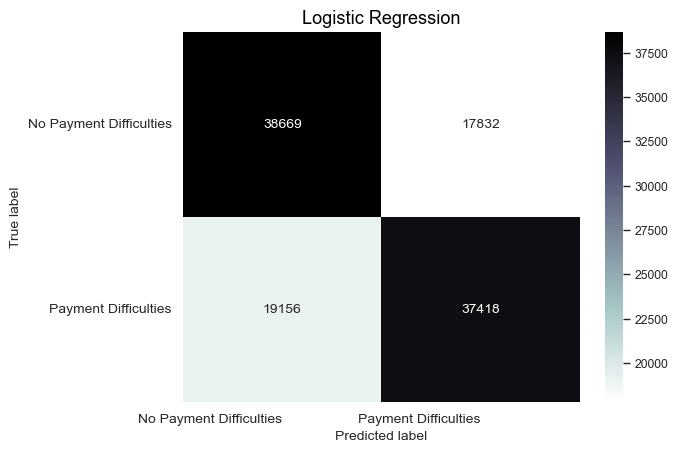

In [219]:
confusion_matrix_log = pd.DataFrame((confusion_matrix(y_test, y_test_pred_log)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_log, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Logistic Regression', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [220]:
acc_log_train=round(log_model.score(X_train,y_train)*100,2)
acc_log_test=round(log_model.score(X_test,y_test)*100,2)
print("training Accuracy: % {}".format(acc_log_train))
print("test Accuracy: % {}".format(acc_log_test))

training Accuracy: % 67.16
test Accuracy: % 67.29


In [222]:
roc_auclog = round(roc_auc_score(y_test, y_test_pred_log),4)
print('roc aug:', roc_auclog)

roc aug: 0.6729


#### 2. Gaussian Naive Bayes

In [223]:
gnb_mod = GaussianNB().fit(X_train, y_train)
print(gnb_mod)

GaussianNB()


In [224]:
y_train_pred_gnb = gnb_mod.predict(X_train)
print(classification_report(y_train, y_train_pred_gnb))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68    226185
           1       0.69      0.37      0.48    226112

    accuracy                           0.60    452297
   macro avg       0.63      0.60      0.58    452297
weighted avg       0.63      0.60      0.58    452297



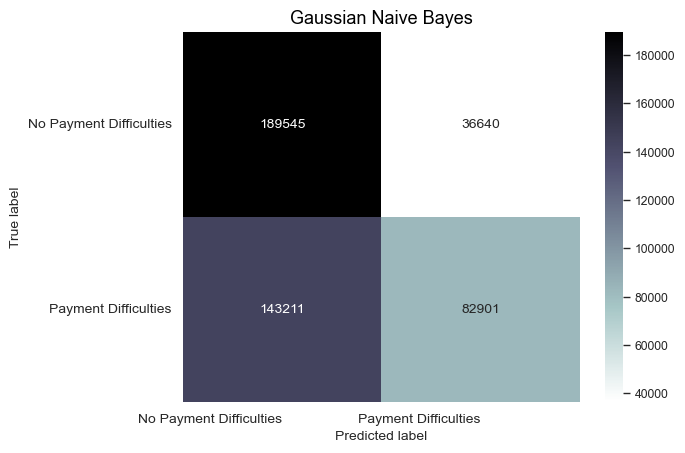

In [225]:
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_train, y_train_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))


plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Gaussian Naive Bayes', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [226]:
y_test_pred_gnb = gnb_model.predict(X_test)
print(classification_report(y_test, y_test_pred_gnb))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68     56501
           1       0.70      0.36      0.48     56574

    accuracy                           0.60    113075
   macro avg       0.63      0.60      0.58    113075
weighted avg       0.64      0.60      0.58    113075



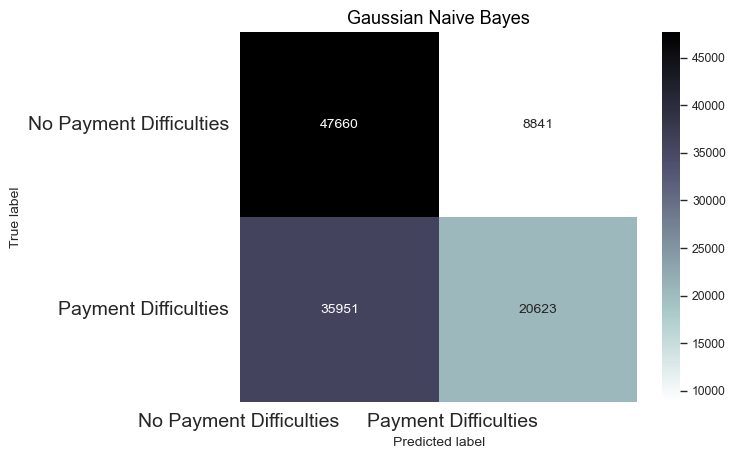

In [227]:
confusion_matrix_gnb = pd.DataFrame((confusion_matrix(y_test, y_test_pred_gnb)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_gnb, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)

plt.title('Gaussian Naive Bayes', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [99]:
acc_nb_train=round(gnb_mod.score(X_train,y_train)*100,2)
acc_nb_test=round(gnb_mod.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nb_train))
print("Test Accuracy: % {}".format(acc_nb_test))

Training Accuracy: % 60.24
Test Accuracy: % 60.39


In [228]:
roc_auc_gnb = round(roc_auc_score(y_test, y_test_pred_gnb),4)
print('roc auc:', roc_auc_gnb)

roc auc: 0.604


#### 3. Decision Tree

In [229]:
dt_mod = DecisionTreeClassifier().fit(X_train,y_train)
print(dt_mod)

DecisionTreeClassifier()


In [230]:
y_train_pred_dt = dt_mod.predict(X_train)
print(classification_report(y_train, y_train_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



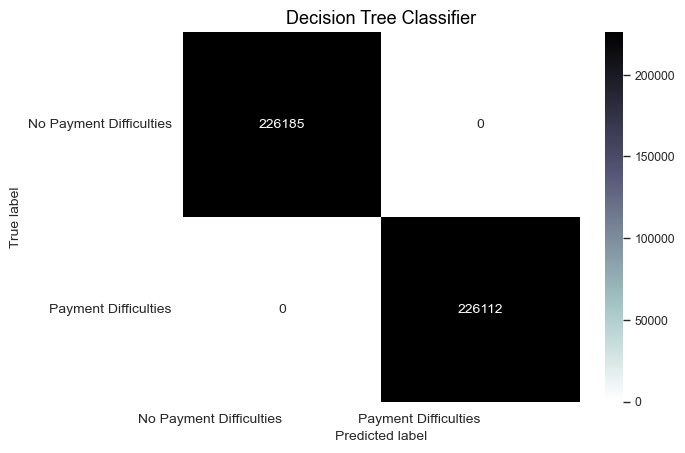

In [231]:
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Decision Tree Classifier', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [232]:
y_test_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_test_pred_dt))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     56501
           1       0.90      0.86      0.88     56574

    accuracy                           0.88    113075
   macro avg       0.88      0.88      0.88    113075
weighted avg       0.88      0.88      0.88    113075



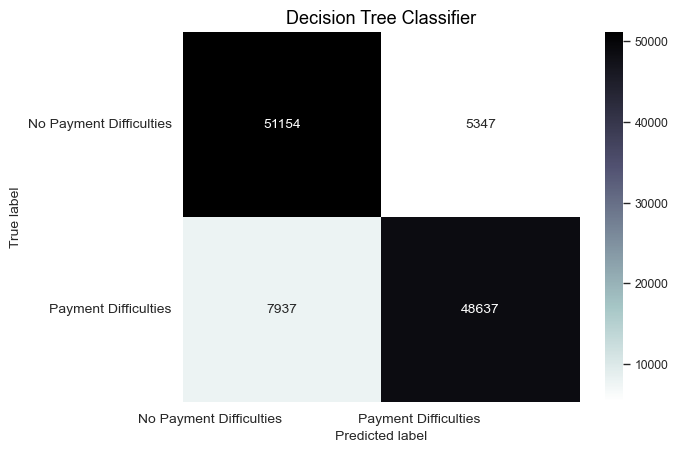

In [233]:
confusion_matrix_dt = pd.DataFrame((confusion_matrix(y_test, y_test_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_dt, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Decision Tree Classifier', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [234]:
acc_dt_train=round(dt_model.score(X_train,y_train)*100,2)
acc_dt_test=round(dt_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_dt_train))
print("Test Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Test Accuracy: % 88.25


In [235]:
roc_auc_dt = round(roc_auc_score(y_test, y_test_pred_dt),4)
print('roc auc:', roc_auc_dt)

roc auc: 0.8825


#### 4. Random Forest

In [108]:
rf_mod = RandomForestClassifier().fit(X_train, y_train)
print(rf_mod)

RandomForestClassifier()


In [236]:
y_train_pred_dt = rf_model.predict(X_train)
print(classification_report(y_train, y_train_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    226185
           1       1.00      1.00      1.00    226112

    accuracy                           1.00    452297
   macro avg       1.00      1.00      1.00    452297
weighted avg       1.00      1.00      1.00    452297



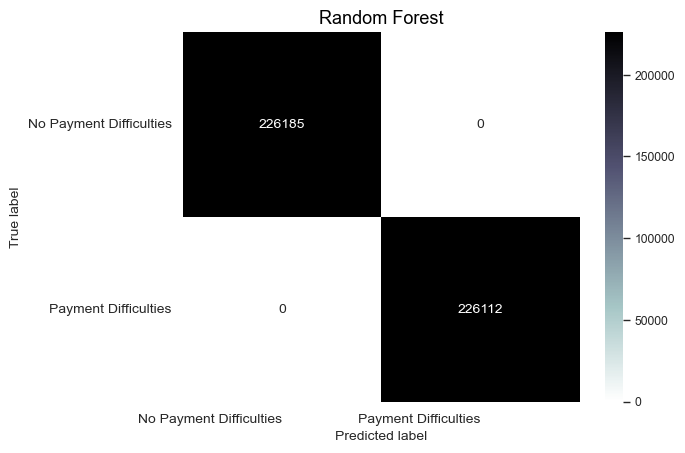

In [238]:
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_train, y_train_pred_dt)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Random Forest', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [239]:
y_test_pred_rf = rf_model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_test_pred_rf))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56501
           1       0.99      1.00      1.00     56574

    accuracy                           1.00    113075
   macro avg       1.00      1.00      1.00    113075
weighted avg       1.00      1.00      1.00    113075



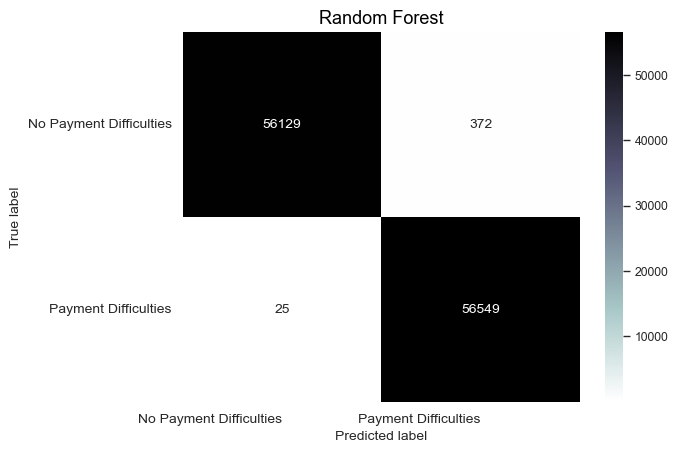

In [240]:
confusion_matrix_rf = pd.DataFrame((confusion_matrix(y_test, y_test_pred_rf)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_rf, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Random Forest', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [241]:
acc_rf_train=round(rf_model.score(X_train,y_train)*100,2)
acc_rf_test=round(rf_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_rf_train))
print("Test Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Test Accuracy: % 99.65


In [242]:
roc_auc_rf = round(roc_auc_score(y_test, y_test_pred_rf),4)
print('roc auc:', roc_auc_rf)

roc auc: 0.9965


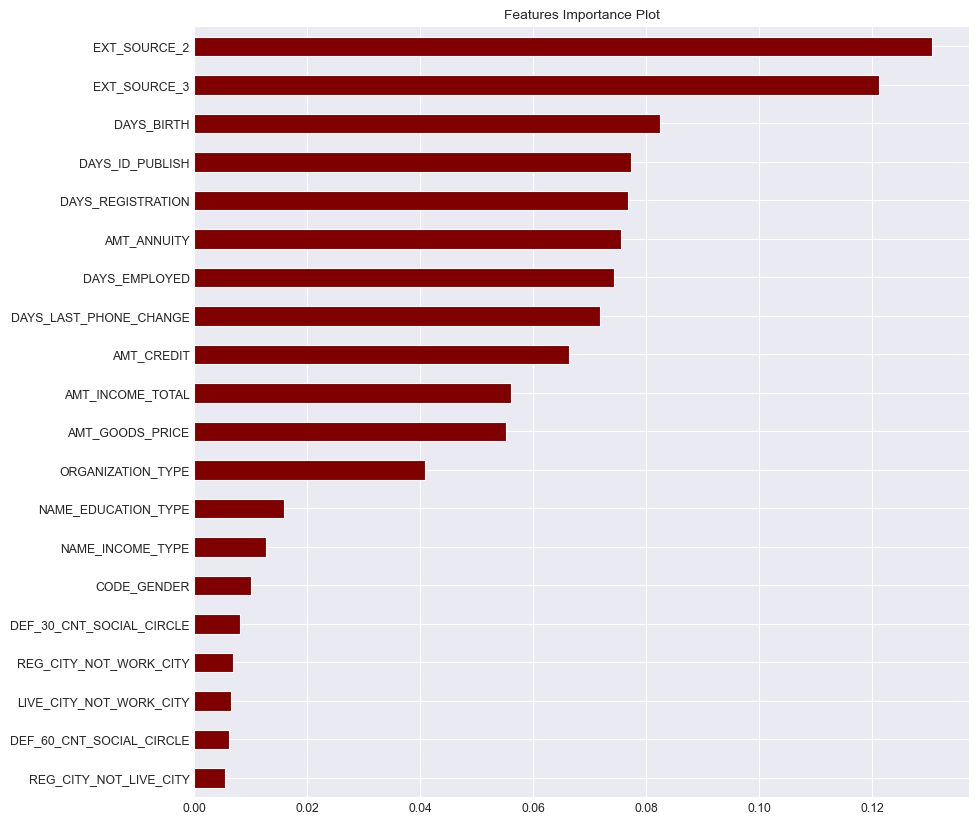

In [243]:
importances_rf = pd.Series(rf_model.feature_importances_, index=x_balanced.columns).sort_values(ascending=True)

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,10))
fig = importances_rf.plot(kind ='barh', color ='maroon')
plt.title('Features Importance Plot', fontsize=10)
plt.show()

fig.figure.tight_layout()
fig.figure.savefig('top feature.png')

#### 5. K-Nearest Neighbors

In [ ]:
knn_mod = KNeighborsClassifier().fit(X_train,y_train)
print(knn_mod)

In [ ]:
y_train_pred_knn = knn_model.predict(X_train)
print(classification_report(y_train, y_train_pred_knn))

In [ ]:
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))


plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('K-Nearest Neighbors', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
y_test_pred_knn = knn_model.predict(X_test)
print(classification_report(y_test, y_test_pred_knn))

In [ ]:
confusion_matrix_knn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_knn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))
plt.figure()
heatmap = sns.heatmap(confusion_matrix_knn, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('K-Nearest Neighbors', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
acc_knn_train=round(knn_mod.score(X_train,y_train)*100,2)
acc_knn_test=round(knn_mod.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_knn_train))
print("Test Accuracy: % {}".format(acc_knn_test))

In [ ]:
roc_auc_knn = round(roc_auc_score(y_test, y_test_pred_knn),4)
print('roc auc:', roc_auc_knn)

#### 6. Neural Network

In [ ]:
nn_mod = MLPClassifier().fit(X_train, y_train)

In [ ]:
y_train_pred_nn = nn_model.predict(X_train)
print(classification_report(y_train, y_train_pred_nn))

In [ ]:
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_train, y_train_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Neural Network', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
y_test_pred_nn = nn_model.predict(X_test)
print(classification_report(y_test, y_test_pred_nn))

In [ ]:
confusion_matrix_nn = pd.DataFrame((confusion_matrix(y_test, y_test_pred_nn)), ('No Payment Difficulties', 'Payment Difficulties'), ('No Payment Difficulties', 'Payment Difficulties'))

plt.figure()
heatmap = sns.heatmap(confusion_matrix_nn, annot=True, annot_kws={'size': 10}, fmt='d', cmap='bone_r')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=10)

plt.title('Neural Network', fontsize=13, color='black')
plt.ylabel('True label', fontsize=10)
plt.xlabel('Predicted label', fontsize=10)
plt.show()

In [ ]:
acc_nn_train=round(nn_model.score(X_train,y_train)*100,2)
acc_nn_test=round(nn_model.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_nn_train))
print("Test Accuracy: % {}".format(acc_nn_test))

In [ ]:
roc_auc_nn = round(roc_auc_score(y_test, y_test_pred_nn),4)
print('roc auc:', roc_auc_nn)

### Model Selection

In [ ]:
results = pd.DataFrame([["Logistic Regression", 0.6716, 0.6729, 0.6729],["Gaussian Naive Bayes", 0.6024, 0.6039, 0.604],
                       ["Decision Tree", 1, 0.8826, 0.8826],["Random Forest", 1, 0.9965, 0.9965],
                       ["K-Nearest Neighbor", 0.9156, 0.8807, 0.8806], ["Neural Network", 0.7001, 0.6948, 0.6948]],
                        columns = ["Models", "Training Accuracy Score", "Testing Accuracy Score", "ROC Score"])

results.sort_values(by=['Training Accuracy Score', 'Testing Accuracy Score'], ascending=False).style.background_gradient(cmap='Blues')

The accuracy of the prediction of train and test data in the Random Forest model has values that are not much different, it can be said that the model is very good because there is no underfitting or overfitting

## Prediction

### Import Dataset

In [ ]:
df_at = pd.read_csv('C:\\Users\\garini\\Downloads\\home-credit-default-risk\\application_test.csv', sep=',')
print('This dataset has %d rows dan %d columns.\n' % df_at.shape)
df_at.head()

There are total 48,744 rows which contains the information of loans and there are 121 features

### Data Preprocessing

#### Detecting Duplication

In [ ]:
print('Count of duplication is:', df_at.duplicated().sum())

#### Detecting Missing Values

In [ ]:
print('Missing values status:', df_at.isnull().values.any())
tmv = pd.DataFrame(df_at.isnull().sum(), columns=['Total Null Values'])
tmv['Percentage'] = (tmv['Total Null Values']/df_at.shape[0])*100
tmv.sort_values(by=['Percentage'], ascending=False).reset_index()

In [ ]:
df_at.drop(df_test.iloc[:, 43:90], inplace=True, axis=1)
df_at.drop(['OWN_CAR_AGE','EXT_SOURCE_1'], inplace=True, axis=1)

In [ ]:
print('Missing values status:', df_at.isnull().values.any())
tmv = pd.DataFrame(df_at.isnull().sum(), columns=['Total Null Values'])
tmv['Percentage'] = (tmv['Total Null Values']/df_at.shape[0])*100
tmv.sort_values(by=['Percentage'], ascending=False).reset_index()

In [ ]:
category_columns = df_test.select_dtypes(include=['object']).columns.tolist()
integer_columns = df_test.select_dtypes(include=['int64','float64']).columns.tolist()

for column in df_test:
    if df_test[column].isnull().any():
        if(column in category_columns):
            df_test[column]=df_test[column].fillna(df_test[column].mode()[0])
        else:
            df_test[column]=df_test[column].fillna(df_test[column].median())

In [ ]:
print('Missing values status:', df_test.isnull().values.any())
tmv= pd.DataFrame(df_test.isnull().sum(), columns=['Total Null Values'])
tmv['Percentage'] = (tmv['Total Null Values']/df_test.shape[0])*100
tmv.sort_values(by=['Percentage'], ascending=False).reset_index()

#### Label Encoding

In [ ]:
df_at[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]] = df_at[["CODE_GENDER", "NAME_CONTRACT_TYPE", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", 
          "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
         "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE"]].apply(LabelEncoder().fit_transform)

In [ ]:
df_at.head()

#### Convert Negative Values to Positive Values

In [ ]:
df_at.iloc[:,16:20] = df_at.iloc[:,16:20].abs()
df_at.iloc[:,45] = df_at.iloc[:,45].abs()

### Prediction

In [ ]:
pred_at = df_at[['DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 
                           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 
                           'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 
                           'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE', 'REG_CITY_NOT_WORK_CITY',
                          'CODE_GENDER', 'EXT_SOURCE_2', 'REG_CITY_NOT_LIVE_CITY', 'NAME_EDUCATION_TYPE',
                          'DEF_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_3', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY']]
pred_at.head()

In [ ]:
predict = pd.Series(rf_model.predict(pred_at), name = "TARGET").astype(int)
results = pd.concat([df_test['SK_ID_CURR'], predict],axis = 1)
results.to_csv("predict application.csv", index = False)
results.head()